# Forecasting 3 Months of Sales
Given 5 years of daily sales data across 10 stores for 50 items, we have been tasked to forecast the next 3 months of sales. We will be exploring the data using Pandas and building models using ARIMA, tensorflow's DNN regressor, and xgboost.

Let's get started!
##### NOTE
This is my first competition and I'm still learning the models myself. At the end I share what I learned while building this.

# Import Libraries
Below are all the libraries that we'll use (with some extra for notebook aesthetics).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='chesterish')

from scipy.spatial.distance import euclidean #used for fdt
import fastdtw as fdt #fast dynamic time warping
from statsmodels.tsa.seasonal import seasonal_decompose #decompose seasonality
from statsmodels.tsa.stattools import adfuller #test if series is stationary (then can perform ARIMA)

from pyramid.arima import auto_arima #auto ARIMA model
import xgboost as xgb #xgboost model
import tensorflow as tf #DNN estimator model

In [2]:
plt.rcParams["figure.figsize"] = [16,9]

# Metrics and 2 Models
## Error Metric
We'll be using the Symmetric Mean Absolute Percentage Error as our forecasting error metric. Defining a function saves us from writing the code multiple times.

In [3]:
def SMAPE (forecast, actual):
    """Returns the Symmetric Mean Absolute Percentage Error between two Series"""
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2
    
    print('SMAPE Error Score: ' + str(round(sum(diff/avg)/len(forecast) * 100, 2)) + ' %')

## Stationarity Test (Dickey Fuller)
Time Series data should be stationary before applying an ARIMA model. Stationary means that the mean, standard deviation, and variance don't change over time. The function below tests whether or not a Time Series is stationary.

In [4]:
def Fuller(TimeSeries):
    """Provides Fuller test results for TimeSeries"""
    stationary_test = adfuller(TimeSeries)
    print('ADF Statistic: %f' % stationary_test[0])
    print('p-value: %f' % stationary_test[1])
    print('Critical Values:')
    for key, value in stationary_test[4].items():
        print('\t%s: %.3f' % (key, value))

## ARIMA Model
General ARIMA model that will be used.

In [5]:
def ARIMA(TimeSeries, maxP, maxQ, maxD):
    """Returns ARIMA model (not fitted)"""
    stepwise_model = auto_arima(TimeSeries, start_p=1, start_q=1,
                           max_p=maxP, max_q=maxQ,
                           start_P=0, seasonal=True,
                           d=1, max_d=maxD, D=1, trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                           maxiter=500)
    print(stepwise_model.aic())
    return stepwise_model

## XGBoost Model
General xgboost model that will be used.

In [6]:
def xboost(x_train, y_train, x_test):
    """Trains xgboost model and returns Series of predictions for x_test"""
    dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=list(x_train.columns))
    dtest = xgb.DMatrix(x_test, feature_names=list(x_test.columns))

    params = {'max_depth':3,
              'eta':0.2,
              'silent':1,
              'subsample':1}
    num_rounds = 1500

    bst = xgb.train(params, dtrain, num_rounds)
    
    return pd.Series(bst.predict(dtest))

# Data Exploration
## Retrieve Data
Open the competition training data. We'll be exploring this before splitting for our models.

In [7]:
df = pd.read_csv('train.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df.tail()

,store,item,sales
date,,,
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74
2017-12-30,10,50,62
2017-12-31,10,50,82


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3)
memory usage: 27.9 MB


## Store Trends
Here we're looking to see if there are any seasonality trends in the total store sales. We'll group by week so we can more clearly see trends in the plots.

In [9]:
stores = pd.DataFrame(df.groupby(['date','store']).sum()['sales']).unstack()
stores = stores.resample('7D',label='left').sum()
stores.sort_index(inplace = True)

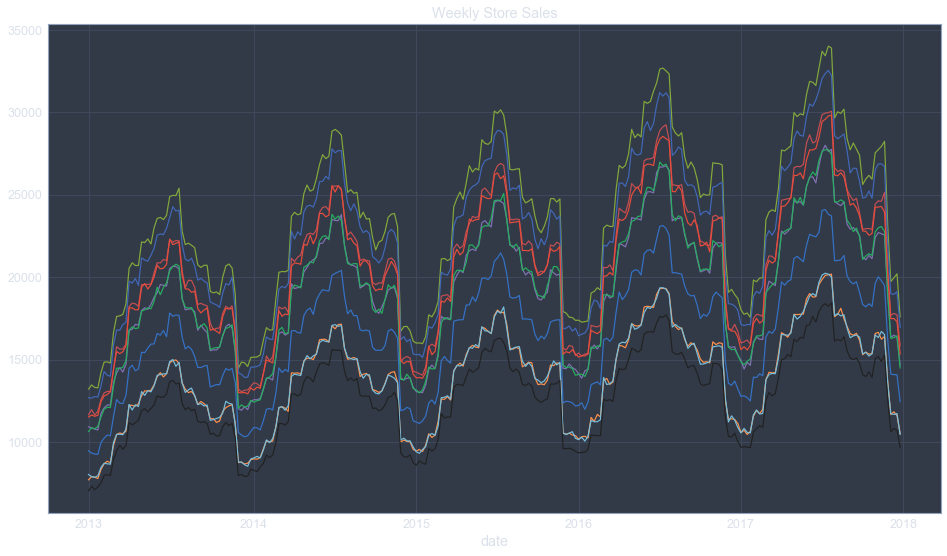

In [10]:
stores.plot(figsize=(16,9), title='Weekly Store Sales', legend=None)
plt.show()

The above plot charts every store's sales by week. But how does the average trend? The 25% quartile?

Let's look:

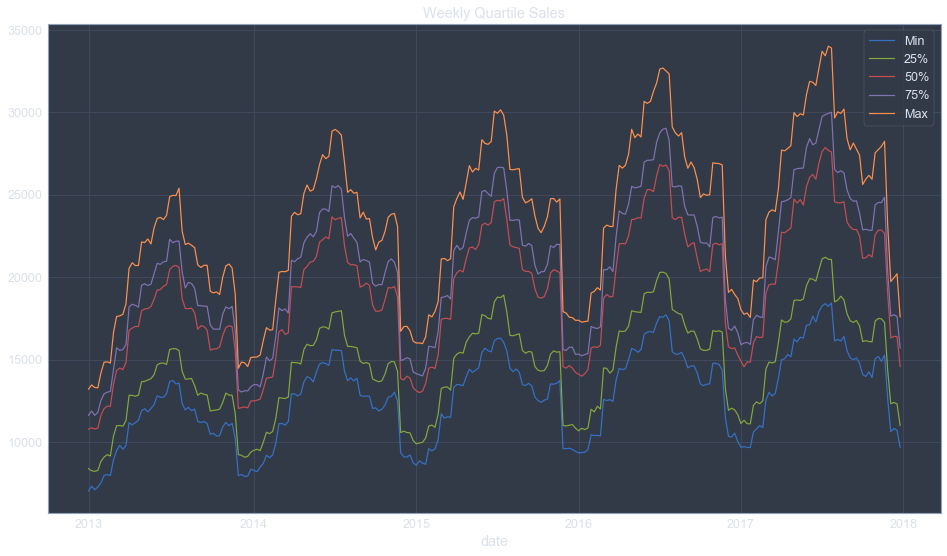

In [11]:
store_qtr = pd.DataFrame(stores.quantile([0.0,0.25,0.5,0.75,1.0],axis=1)).transpose()
store_qtr.sort_index(inplace = True)
store_qtr.columns = ['Min','25%','50%','75%','Max']
store_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

We can see there's quite a gap between the 25% quartile and average. However, as the other chart shows as well, each store shares a general seasonality. They have highs and lows during the same periods of time.

Let's take a look at the seasonality aspect of the average. But before that, we're going to track the week-to-week difference.

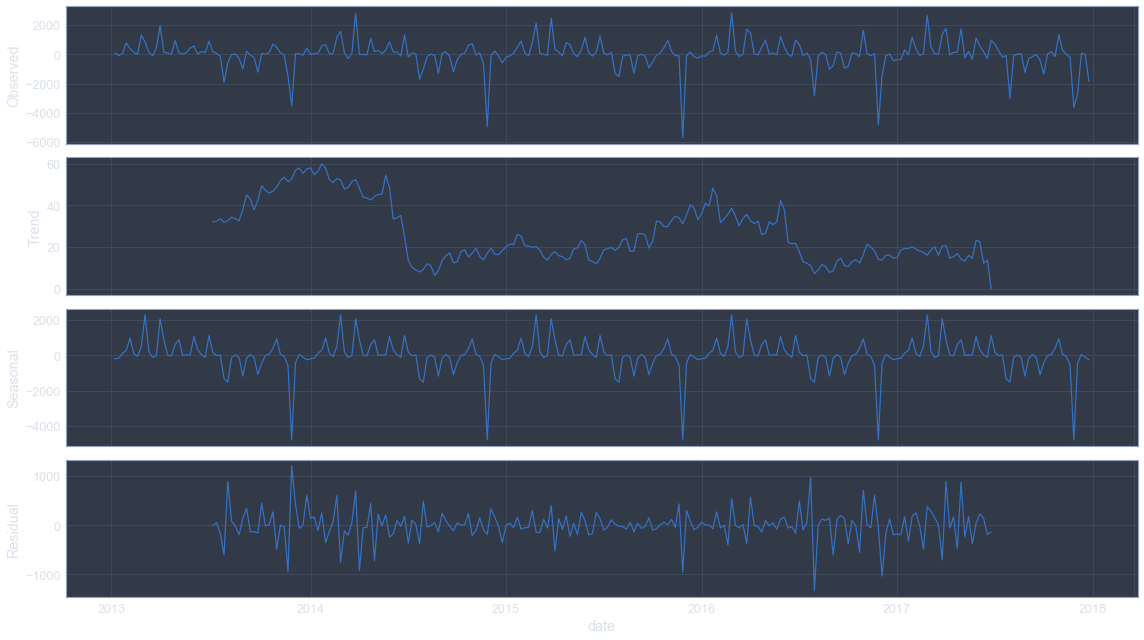

In [12]:
seasonal = seasonal_decompose(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.suptitle = 'Additive Seasonal Decomposition of Average Store Week-to-Week Sales'
plt.show()

In [13]:
Fuller(pd.DataFrame(store_qtr['50%']).diff(1).iloc[1:,0])

ADF Statistic: -5.965889
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


### Store Trends Conclusion
There is definitely seasonality in the store sales. Taking the week-to-week difference provides a dataset that is very likely to be stationary (< 1% chance that it's not). If we were to use this as a starting point for our model, we could cluster the stores to the nearest 25% quartile.

## Item Sales Trends
Now we'll do the same analysis for the total item sales. And again, we're looking at weekly sales.

In [14]:
items = pd.DataFrame(df.groupby(['date','item']).sum()['sales']).unstack()
items = items.resample('7D',label='left').sum()
items.sort_index(inplace = True)

items.tail(13)

sales                                                        ...   \
item          1     2     3     4     5     6     7     8     9     10  ...    
date                                                                    ...    
2017-10-03  1769  4471  2740  1677  1372  4515  4503  5842  3917  5573  ...    
2017-10-10  1758  4454  2858  1757  1392  4483  4510  5932  3861  5771  ...    
2017-10-17  1732  4481  2856  1700  1396  4470  4606  6016  3911  5752  ...    
2017-10-24  1662  4422  2767  1724  1456  4476  4478  6083  3873  5654  ...    
2017-10-31  1774  4798  3087  1680  1476  4766  4837  6415  4276  6088  ...    
2017-11-07  1735  4887  3143  1879  1540  4686  4867  6403  4335  6161  ...    
2017-11-14  1824  4812  3094  1816  1479  4882  4854  6439  4251  5965  ...    
2017-11-21  1818  4840  3076  1876  1576  4835  4936  6427  4181  6053  ...    
2017-11-28  1490  4042  2527  1509  1301  4137  3932  5415  3548  5108  ...    
2017-12-05  1311  3551  2182  1296  1179  3562  3522  4510  3018  4358  ...    
2017-12-12  1308  3498  2251  1277  1125  3541  3381  4699  3014  4372  ...    
2017-12-19  1262  3450  2181  1306  1085  3463  3477  4516  2971  4428  ...    
2017-12-26  1167  3180  1956  1150  1000  2973  3170  4065  2764  3722  ...    

                                                                        
item          41    42    43    44    45    46    47    48    49    50  
date                                                                    
2017-10-03  1629  2845  3963  2416  6089  4620  1696  3973  2285  5054  
2017-10-10  1741  2815  3892  2338  6213  4529  1644  3949  2208  4967  
2017-10-17  1619  2778  4005  2245  6198  4560  1700  3949  2260  5070  
2017-10-24  1644  2761  3927  2346  6404  4494  1739  4021  2202  5074  
2017-10-31  1817  3038  4318  2386  6623  4889  1798  4257  2468  5323  
2017-11-07  1764  3067  4358  2408  6711  4947  1820  4291  2417  5542  
2017-11-14  1807  3076  4315  2424  6774  4884  1755  4318  2475  5349  
2017-11-21  1872  2987  4273  2392  6530  4915  1860  4329  2364  5517  
2017-11-28  1610  2635  3529  2051  5524  4028  1591  3580  1991  4503  
2017-12-05  1280  2148  2985  1756  4695  3510  1283  3101  1669  3829  
2017-12-12  1349  2213  3100  1785  4721  3483  1279  3051  1701  3856  
2017-12-19  1240  2115  3162  1669  4772  3524  1361  3177  1689  3900  
2017-12-26  1124  1893  2680  1546  4349  3182  1166  2655  1546  3411  

[13 rows x 50 columns]

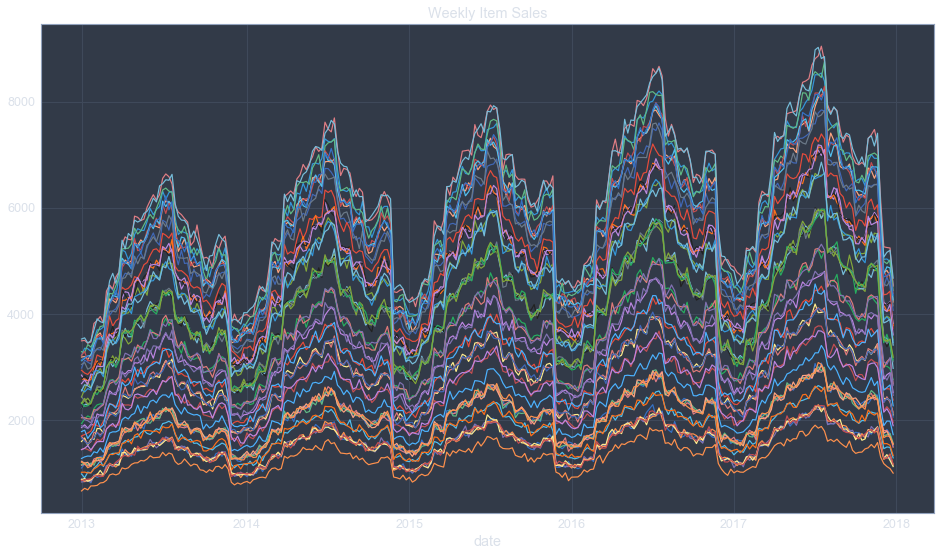

In [15]:
items.plot(figsize=(16,9), title='Weekly Item Sales', legend=None)
plt.show()

Since there are more items than there were stores, we can look at more quartiles. Let's see how every 10% quartile trends.

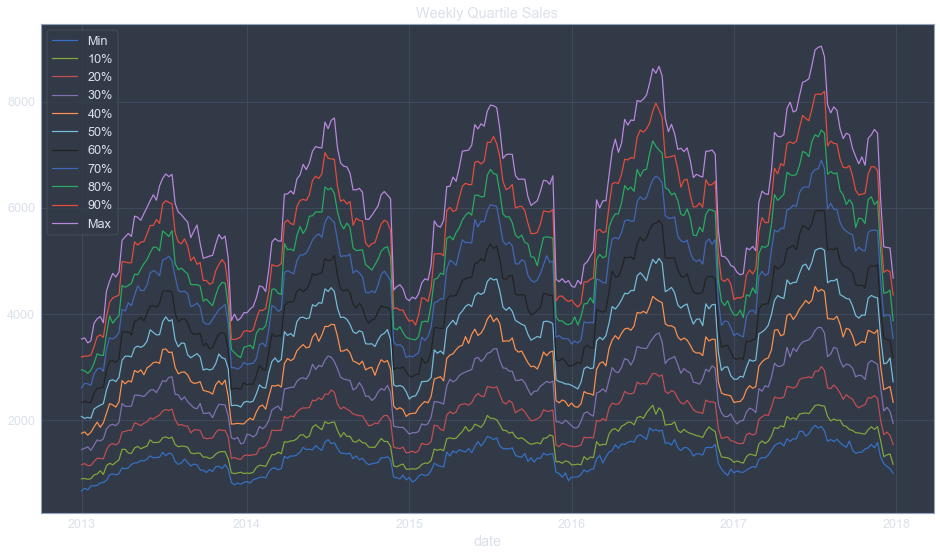

In [16]:
item_WK_qtr = pd.DataFrame(items.quantile([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],axis=1)).transpose()
item_WK_qtr.sort_index(inplace = True)
item_WK_qtr.columns = ['Min','10%','20%','30%','40%','50%','60%','70%','80%','90%','Max']
item_WK_qtr.plot(figsize=(16,9), title='Weekly Quartile Sales')
plt.show()

Like we saw in the store sales plots, there is seasonality in item sales. Let's break out the seasonal component for the average like we had before:

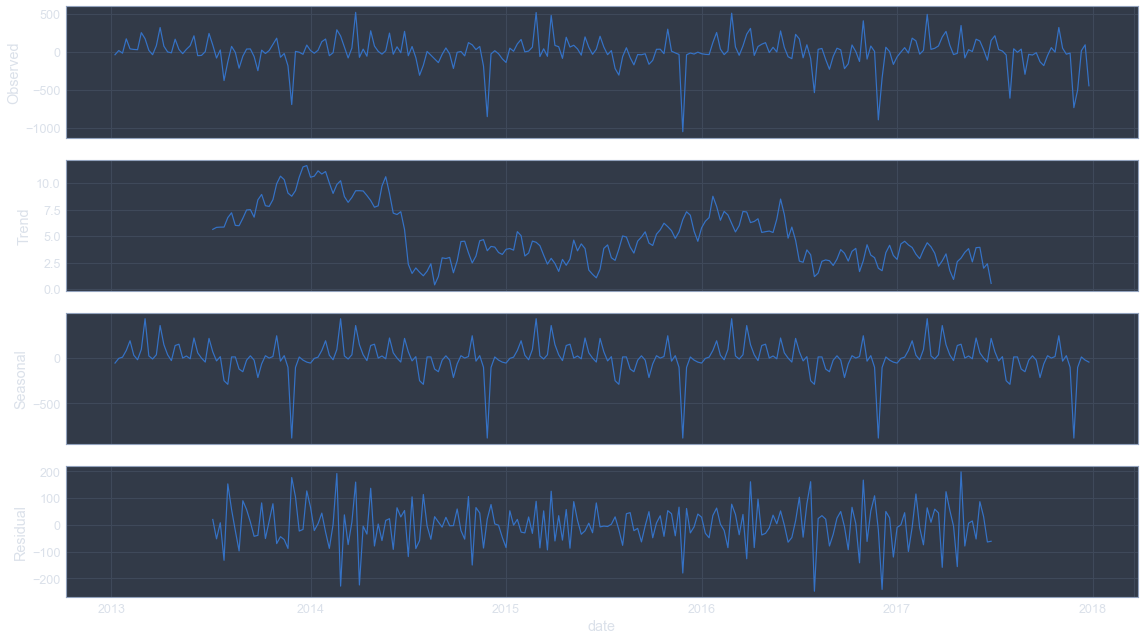

In [17]:
seasonal = seasonal_decompose(pd.DataFrame(item_WK_qtr['50%']).diff(1).iloc[1:,0],model='additive')
seasonal.plot()
plt.title = 'Additive Seasonal Decomposition of Average Item Week-to-Week Sales'
plt.show()

In [18]:
Fuller(pd.DataFrame(item_WK_qtr['50%']).diff(1).iloc[1:,0])

ADF Statistic: -13.061788
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


### Item Trend Conclusion
Item sales are also seasonal. No surprise there. Week-to-week differencing provides a dataset that is very likely to be stationary (< 1% chance that it's not). If we were to use this as a basis for our model, we could cluster the items to the nearest 10% quartiles.

## Store & Item Variability
We've seen how stores and items trend by themselves, but do some stores sell more of one item? In other words: do the stores have the same sales mix? Are the items sold evenly (percentage-wise) across all stores?

Below is a plot for the % distribution of each item's sales across the stores (each row adds to 100%). As we can see, it's very uniform. The takeaway here is that the items are sold evenly across the stores.

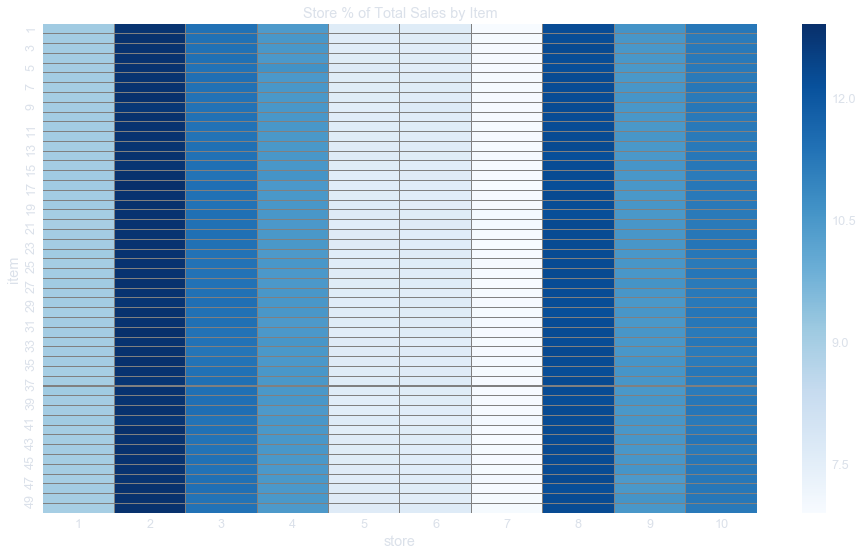

In [19]:
store_item = df.groupby(by=['item','store']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(store_item, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Store % of Total Sales by Item')
plt.show()

Now to confirm, let's look at the % distribution of each store's sales across the different items (each row adds to 100%).

We can see that each store overall sold roughly the same percentage of each item.

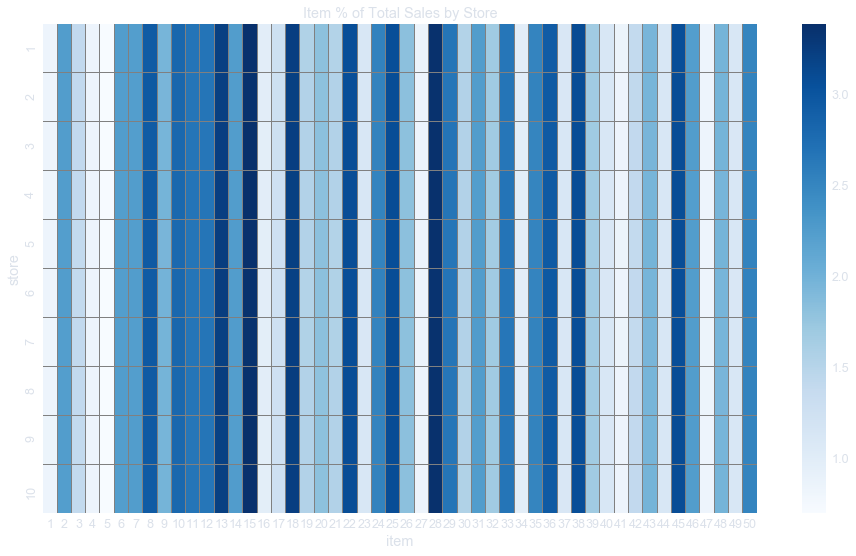

In [20]:
item_store = df.groupby(by=['store','item']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack()
sns.heatmap(item_store , cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Item % of Total Sales by Store')
plt.show()

### Store vs Item Conclusion
Items have roughly same percentage sales across all stores. We could use this in our model.

## Day of Week Variability
How do sales vary by day of week? Is there seasonality as well? Do stores share same trends? 

In [21]:
df['Day'] = df.index.weekday_name
df.head()

,store,item,sales,Day
date,,,,
2013-01-01,1,1,13,Tuesday
2013-01-02,1,1,11,Wednesday
2013-01-03,1,1,14,Thursday
2013-01-04,1,1,13,Friday
2013-01-05,1,1,10,Saturday


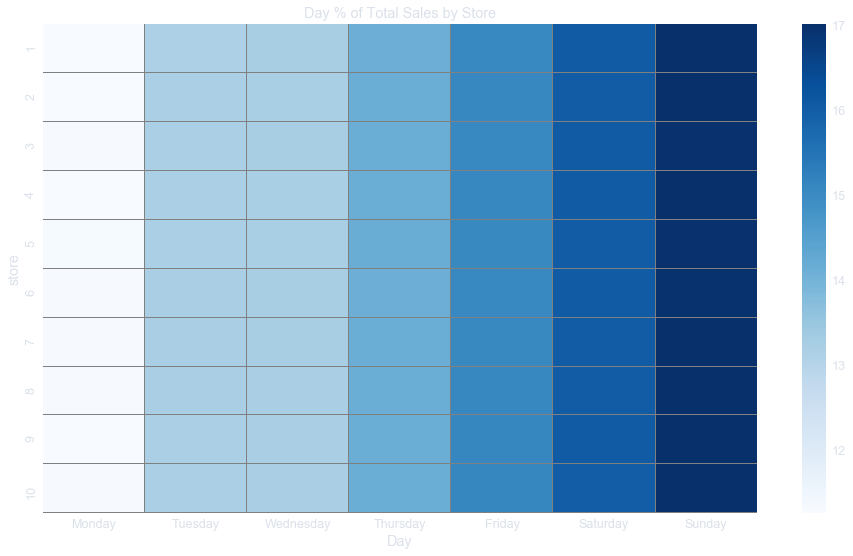

In [22]:
dow_store = df.groupby(['store','Day']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday',
                                                'Tuesday',
                                                'Wednesday',
                                                'Thursday',
                                                'Friday',
                                                'Saturday',
                                                'Sunday']]
sns.heatmap(dow_store, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Day % of Total Sales by Store')
plt.show()

The plot above shows the % mix of store sales by day. We can see that the stores are very similar in what days are popular.

Let's do the same for the items.

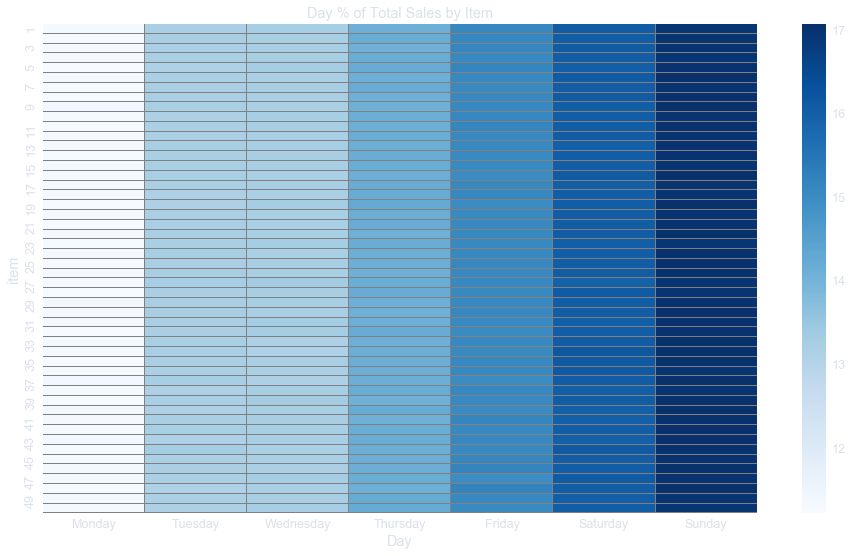

In [23]:
dow_item = df.groupby(['item','Day']).sum()['sales'].groupby(level=0).apply(
    lambda x: 100* x/ x.sum()).unstack().loc[:,['Monday',
                                                'Tuesday',
                                                'Wednesday',
                                                'Thursday',
                                                'Friday',
                                                'Saturday',
                                                'Sunday']]
sns.heatmap(dow_item, cmap='Blues', linewidths=0.01, linecolor='gray').set_title(
    'Day % of Total Sales by Item')
plt.show()

This plot tells us that each item's sales are nearly identical in terms of which days are more popular.

Now let's see if each day generally trends the same as the total week.

In [24]:
dow = pd.DataFrame(df.groupby(['date','Day']).sum()['sales']).unstack()['sales'].loc[:,
                                                                                ['Monday',
                                                                               'Tuesday',
                                                                               'Wednesday',
                                                                               'Thursday',
                                                                               'Friday',
                                                                               'Saturday',
                                                                               'Sunday']]
dow = dow.resample('7D',label='left').sum()
dow.sort_index(inplace = True)

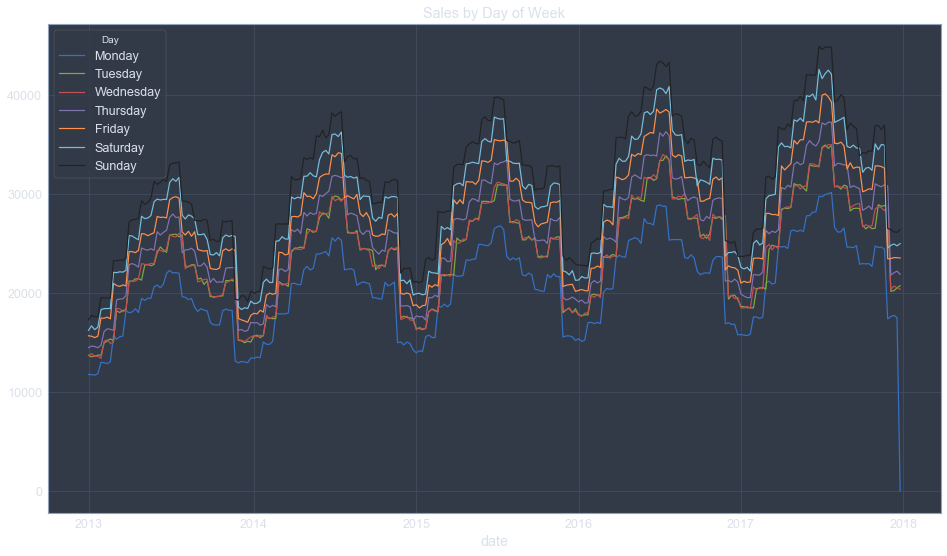

In [25]:
dow.plot(figsize=(16,9), title='Sales by Day of Week')
plt.show()

### Day of Week Conclusion
Day of week does impact sales, however all stores & items have similar distributions. Day of week trends follow general weekly trend.

## Findings and Steps Forward
Items and stores weekly sales have seasonality and can be munged into a stationary dataset. They also have similar day of week variability, and items have roughly same distributions in stores.

### Modeling Process
Split the data into train and test data (3 months of test). Will compare several models, all of which are outlined below. The goal is to find the model with the best accuracy.
#### Model (1.1)
+ Dynamic Time Warping (DTW) on item *__weekly__* sales to cluster to nearest 10% quartile
+ Forecast with *__ARIMA__*
+ Percentages will be used to find item sales by store by day

#### Model (1.2)
+ Forecast weekly item sales with *__ARIMA__*
+ Percentages will be used to find item sales by store by day

#### Model (2)
+ Item *__daily__* sales with added features:
 + Day of year (in mod 364)
 + Day of week (numeric)
 + Month
 + Year
 + Prior year sales
 + Whether or not a weekend (Fri-Sun)
 + Dynamic Time Warping (DTW) on item weekly sales to cluster to nearest 10% quartile
+ Forecast with *__feed forward neural network__*

#### Model (3)
+ Item *__daily__* sales with added features:
 + Day of year (in mod 364)
 + Day of week (numeric)
 + Month
 + Year
 + Prior year sales
 + Whether or not a weekend (Fri-Sun)
 + Dynamic Time Warping (DTW) on item weekly sales to cluster to nearest 10% quartile
+ Forecast with *__xgboost__*

# ARIMA Models
## Model (1.1) - Clustered Weekly Data

Will be using the 10% quartile weekly item sales that was created during the exploratory analysis. Since the competition is predicting the next 3 months of sales, we will use 3 months (13 weeks) of test data.

We will build an ARIMA model for each quartile then use clustering and percentages to arrive at daily items sales by store.

In [26]:
train = item_WK_qtr[:-13]
test = df.loc[df.index >= pd.to_datetime('October 3, 2017')] # last 13 weeks of data

In [27]:
store_pct = store_item.transpose()
store_pct

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
store,,,,,,,,,,,,,,,,,,,,,
1,9.085564,9.073791,9.062798,9.066774,9.049011,9.069617,9.018065,9.028203,9.049435,9.061402,...,9.091271,9.023547,9.015145,9.046201,9.024192,9.011790,9.005155,9.063957,9.020410,9.007414
2,12.816904,12.858324,12.824640,12.828092,12.822540,12.810300,12.823723,12.877231,12.741440,12.850031,...,12.757648,12.910997,12.825060,12.853127,12.828966,12.827383,12.810710,12.857803,12.855471,12.844459
3,11.405039,11.405115,11.399713,11.411098,11.361155,11.453447,11.386753,11.373289,11.381009,11.387498,...,11.357555,11.392619,11.345828,11.356511,11.398149,11.382714,11.416667,11.430911,11.337725,11.377637
4,10.435394,10.536256,10.520157,10.488994,10.635385,10.472900,10.528670,10.502894,10.516433,10.521691,...,10.529945,10.504758,10.531103,10.528659,10.509172,10.474110,10.504977,10.469840,10.513140,10.461351
5,7.615152,7.595244,7.596620,7.622161,7.672941,7.617378,7.608884,7.610874,7.557394,7.580473,...,7.649611,7.558458,7.634991,7.624657,7.622733,7.628759,7.589458,7.649330,7.626250,7.637765
6,7.605435,7.603005,7.589895,7.611960,7.567640,7.606987,7.619737,7.587459,7.678561,7.588026,...,7.548057,7.602791,7.609901,7.593175,7.587462,7.595511,7.593689,7.604753,7.561284,7.667690
7,6.896388,6.951524,6.967704,6.977734,6.936133,6.957439,6.955239,6.981670,6.986196,6.985992,...,7.031828,6.933015,6.906426,6.954962,6.937566,6.962599,7.034927,6.937165,6.956239,6.955393
8,12.275527,12.233490,12.301689,12.243629,12.216389,12.299760,12.255129,12.275640,12.296844,12.265646,...,12.287964,12.304810,12.278209,12.311782,12.278019,12.279176,12.339060,12.216875,12.283843,12.290432
9,10.611534,10.549439,10.516570,10.517856,10.497569,10.497144,10.560575,10.563672,10.528475,10.529543,...,10.540399,10.532970,10.557261,10.534061,10.559598,10.574879,10.454452,10.511004,10.585387,10.520038


##### Dynamic Time Warping to 10% Quartiles
Matches each item to nearest 10% quartile. Outputs list of item id, % quartile /10, and dtw score.

In [28]:
fitted_items_WK = []
qtr_list = [0] *11

for column in items:
    for c in range(11):
        qtr_list[c] = [fdt.fastdtw(items[column],item_WK_qtr.iloc[:,c], dist= euclidean)[0], c]
    qtr_list.sort()
    fitted_items_WK.append([column[1], qtr_list[0][1], qtr_list[0][0]])

##### Fitting Models and Forecasting

In [29]:
ARIMA_predictions = pd.DataFrame()

for column in item_WK_qtr:
    model = ARIMA(item_WK_qtr[column], 52, 52, 52)
    model.fit(train[column])
    ARIMA_predictions[column] = model.predict(n_periods=13)

3049.6417768558194
3086.614564046098
3197.7717643577444
3332.275339581939
3405.889532659832
3475.136067209135
3538.465431648969
3604.1951850408213
3658.8425632919193
3700.589050589141
3749.329421354075


In [30]:
item_WK_predictions = pd.DataFrame()

for i in range(50):
    item_WK_predictions[fitted_items_WK[i][0]] = ARIMA_predictions.iloc[:,fitted_items_WK[i][1]]

item_WK_predictions.head()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,1806.647165,4775.086934,2973.300279,1806.647165,1433.101215,4775.086934,4775.086934,6063.280035,4131.408858,6063.280035,...,1806.647165,2973.300279,4131.408858,2394.891201,6575.725694,4775.086934,1806.647165,4131.408858,2394.891201,5497.297984
1,1810.191385,4783.570536,2979.141170,1810.191385,1436.202429,4783.570536,4783.570536,6073.639819,4139.012251,6073.639819,...,1810.191385,2979.141170,4139.012251,2399.891614,6588.217021,4783.570536,1810.191385,4139.012251,2399.891614,5507.238798
2,1813.735605,4792.054137,2984.982061,1813.735605,1439.303644,4792.054137,4792.054137,6085.851934,4146.615644,6085.851934,...,1813.735605,2984.982061,4146.615644,2404.892026,6600.708348,4792.054137,1813.735605,4146.615644,2404.892026,5517.179611
3,1817.279824,4800.537739,2990.822952,1817.279824,1442.404858,4800.537739,4800.537739,6098.338985,4154.219036,6098.338985,...,1817.279824,2990.822952,4154.219036,2409.892439,6613.199676,4800.537739,1817.279824,4154.219036,2409.892439,5527.120425
4,1820.824044,4809.021341,2996.663842,1820.824044,1445.506073,4809.021341,4809.021341,6110.866845,4161.822429,6110.866845,...,1820.824044,2996.663842,4161.822429,2414.892851,6625.691003,4809.021341,1820.824044,4161.822429,2414.892851,5537.061238


##### Convert Item Weekly Predictions to Daily Predictions
Use day of week percentages from before to calculate daily item sales.

In [31]:
item_Day_pred = []

for column in item_WK_predictions:
    for i, row in item_WK_predictions.iterrows():
        for col in range(7):
            item_Day_pred.append([i, dow_item.columns[col], column, dow_item.iloc[int(column)-1,col]
                                 * item_WK_predictions[column][i]/100])
            
item_Day_fcst = pd.DataFrame(item_Day_pred, columns=['Week #','Day','item','Prediction'])

item_Day_fcst.head()

,Week #,Day,item,Prediction
0,0,Monday,1,204.356413
1,0,Tuesday,1,238.240275
2,0,Wednesday,1,239.820141
3,0,Thursday,1,254.777112
4,0,Friday,1,273.082859


##### Split Predictions by Store
Reshape the store_item DataFrame and use percentages to calculate daily item sales by store.

In [32]:
store_item = pd.DataFrame(store_item.stack()).reset_index()
store_item.columns = ['item','store','pct']

item_Day_fcst = item_Day_fcst.merge(store_item, on= 'item')

item_Day_fcst['sales'] = item_Day_fcst['Prediction'] * item_Day_fcst['pct']/100

In [33]:
item_Day_fcst = item_Day_fcst.loc[:,['Week #','Day','store','item','sales']]

item_Day_fcst.head()

,Week #,Day,store,item,sales
0,0,Monday,1,1,18.566933
1,0,Monday,2,1,26.192164
2,0,Monday,3,1,23.306928
3,0,Monday,4,1,21.325396
4,0,Monday,5,1,15.562051


##### Convert Week Number and Day of Week into Datetime
Based on where the data was split for testing, the weeks start on Tuesdays so there's no offset then. This adds an additional day of data that we'll need to cutoff.

This is needed so we can remove the additional day in a readable way.

In [34]:
def str_to_date(row):
    """Takes day of week string and week offset to calculate date"""
    switcher = {
        'Tuesday': 0, #data starts on a Tuesday, so 0 offset
        'Wednesday': 1,
        'Thursday': 2,
        'Friday': 3,
        'Saturday': 4,
        'Sunday': 5,
        'Monday': 6
    }
    weeks = pd.to_timedelta(7* row['Week #'], unit='D')
    days = pd.to_timedelta(switcher.get(row['Day']), unit='D')
    
    return pd.to_datetime('October 3, 2017') + weeks + days


item_Day_fcst['Date'] = item_Day_fcst.apply(lambda row: str_to_date(row), axis=1)
item_Day_fcst.index = item_Day_fcst['Date']

In [35]:
item_Day_fcst.sort_values(['item','store','Date'], inplace=True)
item_Day_fcst['sales']= round(item_Day_fcst['sales'], 0)

item_Day_fcst = item_Day_fcst[['store','item','sales']].loc[
    item_Day_fcst.index < pd.to_datetime('January 1, 2018')]

##### Model Accuracy
The predictions have been organized the same as the testing data, so we can simply plug both into our error function.

In [36]:
SMAPE(item_Day_fcst['sales'], test['sales'])

SMAPE Error Score: 19.49 %


## Model (1.2) - Unclustered Weekly Data

Now that we've forecasted item quartiles, let's forecast for each item separately. This is to see if there's a difference in accuracy.

We will build an ARIMA model for each item then use percentages to arrive at daily items sales by store.

In [37]:
train = items['sales'][:-13]

##### Fitting Models and Forecasting

In [38]:
item_WK_predictions = pd.DataFrame()

for column in items['sales']:
    model = ARIMA(items['sales'][column], 52, 52, 52)
    model.fit(train[column])
    item_WK_predictions[column] = model.predict(n_periods=13)

3132.3158963255437
3568.9800426972683
3359.7771883190835
3122.5780533271814
3049.6417768558194
3580.229254385328
3561.3331717814176
3695.4787836182877
3504.379666448102
3665.542130430781
3663.5626520544383
3669.8318790548547
3727.3592227114063
3574.4855673203238
3772.91378609851
3153.761550795569
3287.017066475818
3772.766637574263
3411.2445495127563
3461.8883172498045
3393.514334060449
3719.866754169827
3258.4976881970556
3623.2924199545314
3729.9257823073794
3491.206406947083
3120.520039991852
3757.758829165792
3656.8606818337425
3400.9636511125123
3567.602307885823
3432.8545622315305
3652.777863292133
3200.4858251200394
3634.404507088175
3704.174192120304
3250.961045912688
3728.2395943296383
3442.9765421745233
3265.1651186613567
3128.457780739028
3357.05785617987
3517.429984216851
3258.262527458498
3723.265970789171
3579.6774082799107
3102.3772236083432
3481.5795254357604
3260.9430576455725
3633.7497695353177


##### Convert Item Weekly Predictions to Daily Predictions
Using day of week percentages from before.

In [39]:
item_Day_pred = []

for column in item_WK_predictions:
    for i, row in item_WK_predictions.iterrows():
        for col in range(7):
            item_Day_pred.append([i, dow_item.columns[col], column, dow_item.iloc[int(column)-1,col]
                                 * item_WK_predictions[column][i]/100])
            
item_Day_fcst = pd.DataFrame(item_Day_pred, columns=['Week #','Day','item','Prediction'])

item_Day_fcst.head()

,Week #,Day,item,Prediction
0,0,Monday,1,197.205136
1,0,Tuesday,1,229.903261
2,0,Wednesday,1,231.427842
3,0,Thursday,1,245.861406
4,0,Friday,1,263.526559


##### Split Predictions by Store
Reshape the store_item DataFrame and use percentages.

In [40]:
item_Day_fcst = item_Day_fcst.merge(store_item, on= 'item')

item_Day_fcst['sales'] = item_Day_fcst['Prediction'] * item_Day_fcst['pct']/100

In [41]:
item_Day_fcst = item_Day_fcst.loc[:,['Week #','Day','store','item','sales']]

##### Convert Week Number and Day of Week into Datetime

In [42]:
item_Day_fcst['Date'] = item_Day_fcst.apply(lambda row: str_to_date(row), axis=1)
item_Day_fcst.index = item_Day_fcst['Date']

In [43]:
item_Day_fcst.sort_values(['item','store','Date'], inplace=True)
item_Day_fcst['sales']= round(item_Day_fcst['sales'], 0)

item_Day_fcst = item_Day_fcst[['store','item','sales']].loc[
    item_Day_fcst.index < pd.to_datetime('January 1, 2018')]

##### Model Accuracy

In [44]:
SMAPE(item_Day_fcst['sales'], test['sales'])

SMAPE Error Score: 19.6 %


# DNN Model
## Model (2) - Feed Forward Neural Network with Daily Data

To really take advantage of the DNN, we need to add features. We won't be adding any rolling/ expanding windows since they'd be unreliable on the competition data. Most of the engineered features are categorical, with the exception being prior year sales.

Below are some constants we'll need to use for working with datetimes.

In [45]:
ns_per_day = 86400000000000
start_date = pd.to_datetime('January 1, 2013')

### Feature Engineering
**Day of Week**
 + Utilizing pandas builtin dayofweek call to create binary columns for each day of week.

**Month**
 + Utilizing pandas buitlin month call.
 
**Day of Year**
 + Take the number of days since the data started, then take (mod 364) for a like-for-like day of year.
 + Want to do this instead of calendar day of year because the dates land on different days of the week. Example: January 1 might be a Tuesday one year so it'll be a Wednesday next year.
 
**Day of Quarter**
 + Take the number of days since the data started, then take the quotient when divided by 91 and put into (mod 4).
 + This is to give us similar quarters, same reasoning as above.
 
**Quarter**
 + Take the number of days since the data started, then take the quotient when divided by 91.
 + This is to give us similar quarters.
 
**Is Weekend**
 + Boolean value if the date falls on a weekend. This is because a majority of sales occur between Friday and Sunday.
 
**Item Quart**
 + Which quartile trend the item most closely resembles. This comes from the dynamic time warping we had done for the ARIMA models.
 
**12 Month Lag**
 + Prior year's sales (same store, same item, 364 days prior).

In [46]:
itm_quart = pd.DataFrame(fitted_items_WK, columns=['item','item_quart','item_metric'])

def add_feat(df):
    """Takes DataFrame and returns DataFrame with added features"""
    
    dataf = df

    dataf['Is_Mon'] = (dataf.index.dayofweek == 0) *1
    dataf['Is_Tue'] = (dataf.index.dayofweek == 1) *1
    dataf['Is_Wed'] = (dataf.index.dayofweek == 2) *1
    dataf['Is_Thu'] = (dataf.index.dayofweek == 3) *1
    dataf['Is_Fri'] = (dataf.index.dayofweek == 4) *1
    dataf['Is_Sat'] = (dataf.index.dayofweek == 5) *1
    dataf['Is_Sun'] = (dataf.index.dayofweek == 6) *1
    dataf['Day_Num'] = ((dataf.index - start_date)/ ns_per_day).astype(int)
    
    dataf['Month'] = dataf.index.month
    dataf['Day_of_Year'] = ((dataf.index - start_date)/ ns_per_day).astype(int) % 364
    dataf['Year'] = ((dataf.index - start_date)/ ns_per_day).astype(int) // 364 -1
    dataf['Day_of_Quarter'] = ((dataf.index - start_date)/ ns_per_day).astype(int) % 91
    dataf['Quarter'] = (((dataf.index - start_date)/ ns_per_day).astype(int) // 91) % 4
    dataf['is_wknd'] = dataf.index.dayofweek // 4 # Fri-Sun are 4-6, Monday is 0 so this is valid
    dataf.reset_index(inplace=True)
    
    # Add item quartile as feature
    dataf = dataf.merge(itm_quart, on='item').drop('item_metric', axis=1)

    # Add prior year sales as additional column/ feature
    prior_year_sales = dataf[['date','sales','store','item']]
    prior_year_sales['date'] += pd.Timedelta('364 days')
    prior_year_sales.columns =['date','lag_12mo','store','item']

    dataf = dataf.merge(prior_year_sales, on=['date','store','item'])
    
    #id's start at 0 instead of 1
    dataf['store'] -=1
    dataf['item'] -=1
    
    # Remove first year of data as there is no prior year sales for them
    dataf = dataf[dataf['Year'] >=0].drop('Year', axis=1)
    
    return dataf

In [47]:
df_test = add_feat(df)

df_test.tail(10)

C:\Users\Andy\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,date,store,item,sales,Day,Is_Mon,Is_Tue,Is_Wed,Is_Thu,Is_Fri,Is_Sat,Is_Sun,Day_Num,Month,Day_of_Year,Day_of_Quarter,Quarter,is_wknd,item_quart,lag_12mo
730990,2017-12-22,9,49,75,Friday,0,0,0,0,1,0,0,1816,12,360,87,3,1,7,64
730991,2017-12-23,9,49,70,Saturday,0,0,0,0,0,1,0,1817,12,361,88,3,1,7,65
730992,2017-12-24,9,49,76,Sunday,0,0,0,0,0,0,1,1818,12,362,89,3,1,7,64
730993,2017-12-25,9,49,51,Monday,1,0,0,0,0,0,0,1819,12,363,90,3,0,7,61
730994,2017-12-26,9,49,41,Tuesday,0,1,0,0,0,0,0,1820,12,0,0,0,0,7,60
730995,2017-12-27,9,49,63,Wednesday,0,0,1,0,0,0,0,1821,12,1,1,0,0,7,43
730996,2017-12-28,9,49,59,Thursday,0,0,0,1,0,0,0,1822,12,2,2,0,0,7,68
730997,2017-12-29,9,49,74,Friday,0,0,0,0,1,0,0,1823,12,3,3,0,1,7,63
730998,2017-12-30,9,49,62,Saturday,0,0,0,0,0,1,0,1824,12,4,4,0,1,7,64
730999,2017-12-31,9,49,82,Sunday,0,0,0,0,0,0,1,1825,12,5,5,0,1,7,69


In [48]:
df_test.head(10)

,date,store,item,sales,Day,Is_Mon,Is_Tue,Is_Wed,Is_Thu,Is_Fri,Is_Sat,Is_Sun,Day_Num,Month,Day_of_Year,Day_of_Quarter,Quarter,is_wknd,item_quart,lag_12mo
0,2013-12-31,0,0,15,Tuesday,0,1,0,0,0,0,0,364,12,0,0,0,0,1,13
1,2014-01-01,0,0,9,Wednesday,0,0,1,0,0,0,0,365,1,1,1,0,0,1,11
2,2014-01-02,0,0,14,Thursday,0,0,0,1,0,0,0,366,1,2,2,0,0,1,14
3,2014-01-03,0,0,11,Friday,0,0,0,0,1,0,0,367,1,3,3,0,1,1,13
4,2014-01-04,0,0,20,Saturday,0,0,0,0,0,1,0,368,1,4,4,0,1,1,10
5,2014-01-05,0,0,17,Sunday,0,0,0,0,0,0,1,369,1,5,5,0,1,1,12
6,2014-01-06,0,0,14,Monday,1,0,0,0,0,0,0,370,1,6,6,0,0,1,10
7,2014-01-07,0,0,11,Tuesday,0,1,0,0,0,0,0,371,1,7,7,0,0,1,9
8,2014-01-08,0,0,12,Wednesday,0,0,1,0,0,0,0,372,1,8,8,0,0,1,12
9,2014-01-09,0,0,17,Thursday,0,0,0,1,0,0,0,373,1,9,9,0,0,1,9


### Train & Test Data Split
Split train and test data by setting the last 91 days (everything after October 3, 2017) as test data.

In [49]:
x_train = df_test.loc[df['date'] < pd.to_datetime('October 3, 2017')].drop(['sales','date','Day'], axis=1)
y_train = df_test.loc[df['date'] < pd.to_datetime('October 3, 2017'), 'sales']

x_test = df_test.loc[df['date'] >= pd.to_datetime('October 3, 2017')].drop(['sales','date','Day'], axis=1).reset_index(drop=True)
y_test = df_test.loc[df['date'] >= pd.to_datetime('October 3, 2017'), 'sales'].reset_index(drop=True)

### Feature Columns
Setup the feature colunms in the tensorflow model. Most of the features are categorical, the only numeric one is 'lag_12mo'

In [51]:
feat_cols =[]

for col in x_train.drop('lag_12mo', axis=1).columns:
    feat_cols.append(tf.feature_column.embedding_column(
        tf.feature_column.categorical_column_with_identity(col, max(df_test[col])+1),1))
    
feat_cols.append(tf.feature_column.numeric_column(key='lag_12mo'))

### Training the Model & Forecasting
Setup the training (input) function in tensorflow. Sending 6 months (180 days) of data to train on at once and will run through the entire dataset 80 times. We won't shuffle the observations for this exercise. Idea being that the order of observations matters since this is a time series.

In [52]:
input_func = tf.estimator.inputs.pandas_input_fn(x= x_train, y= y_train, batch_size= 180, num_epochs= 80,
                                                 shuffle= False)

The model we'll use is tensorflow's builtin DNNRegressor with 3 hidden layers.

In [53]:
regressor = tf.estimator.DNNRegressor(hidden_units= [20, 10, 20], feature_columns= feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Andy\\AppData\\Local\\Temp\\tmppnirs0ta', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001AEA5004198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [54]:
regressor.train(input_fn= input_func)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Andy\AppData\Local\Temp\tmppnirs0ta\model.ckpt.
INFO:tensorflow:loss = 73516.0, step = 1
INFO:tensorflow:global_step/sec: 85.9601
INFO:tensorflow:loss = 18455.105, step = 101 (1.165 sec)
INFO:tensorflow:global_step/sec: 268.25
INFO:tensorflow:loss = 11057.607, step = 201 (0.373 sec)
INFO:tensorflow:global_step/sec: 266.111
INFO:tensorflow:loss = 8528.085, step = 301 (0.377 sec)
INFO:tensorflow:global_step/sec: 261.931
INFO:tensorflow:loss = 34313.844, step = 401 (0.380 sec)
INFO:tensorflow:global_step/sec: 268.973
INFO:tensorflow:loss = 13322.642, step = 501 (0.373 sec)
INFO:tensorflow:global_step/sec: 271.895
INFO:tensorflow:loss = 33306.055, step = 601 (0.368 sec)
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:loss = 3617.3047, step = 8001 (0.383 sec)
INFO:tensorflow:global_step/sec: 266.82
INFO:tensorflow:loss = 3719.1287, step = 8101 (0.373 sec)
INFO:tensorflow:global_step/sec: 248.9
INFO:tensorflow:loss = 19434.219, step = 8201 (0.402 sec)
INFO:tensorflow:global_step/sec: 265.404
INFO:tensorflow:loss = 20863.408, step = 8301 (0.379 sec)
INFO:tensorflow:global_step/sec: 271.896
INFO:tensorflow:loss = 16797.201, step = 8401 (0.367 sec)
INFO:tensorflow:global_step/sec: 278.712
INFO:tensorflow:loss = 18512.791, step = 8501 (0.359 sec)
INFO:tensorflow:global_step/sec: 267.534
INFO:tensorflow:loss = 16461.447, step = 8601 (0.374 sec)
INFO:tensorflow:global_step/sec: 256.558
INFO:tensorflow:loss = 15716.4795, step = 8701 (0.389 sec)
INFO:tensorflow:global_step/sec: 245.841
INFO:tensorflow:loss = 19838.262, step = 8801 (0.408 sec)
INFO:tensorflow:global_step/sec: 258.546
INFO:tensorflow:loss = 8336.007, step = 8901 (0.387 sec)
INFO:tensorflow:global_step/sec: 249.521
INFO:tensorfl

INFO:tensorflow:loss = 20221.93, step = 16301 (0.384 sec)
INFO:tensorflow:global_step/sec: 255.902
INFO:tensorflow:loss = 17223.414, step = 16401 (0.389 sec)
INFO:tensorflow:global_step/sec: 255.245
INFO:tensorflow:loss = 8886.71, step = 16501 (0.394 sec)
INFO:tensorflow:global_step/sec: 271.163
INFO:tensorflow:loss = 28621.348, step = 16601 (0.368 sec)
INFO:tensorflow:global_step/sec: 264.003
INFO:tensorflow:loss = 12885.821, step = 16701 (0.379 sec)
INFO:tensorflow:global_step/sec: 264.005
INFO:tensorflow:loss = 14856.345, step = 16801 (0.377 sec)
INFO:tensorflow:global_step/sec: 259.89
INFO:tensorflow:loss = 8019.8457, step = 16901 (0.388 sec)
INFO:tensorflow:global_step/sec: 259.216
INFO:tensorflow:loss = 10095.875, step = 17001 (0.386 sec)
INFO:tensorflow:global_step/sec: 259.217
INFO:tensorflow:loss = 19352.887, step = 17101 (0.384 sec)
INFO:tensorflow:global_step/sec: 266.111
INFO:tensorflow:loss = 9181.416, step = 17201 (0.377 sec)
INFO:tensorflow:global_step/sec: 250.77
INFO:t

INFO:tensorflow:global_step/sec: 274.13
INFO:tensorflow:loss = 9208.568, step = 24601 (0.365 sec)
INFO:tensorflow:global_step/sec: 268.972
INFO:tensorflow:loss = 11335.255, step = 24701 (0.372 sec)
INFO:tensorflow:global_step/sec: 275.641
INFO:tensorflow:loss = 17615.605, step = 24801 (0.362 sec)
INFO:tensorflow:global_step/sec: 274.13
INFO:tensorflow:loss = 4023.9717, step = 24901 (0.366 sec)
INFO:tensorflow:global_step/sec: 273.381
INFO:tensorflow:loss = 15610.959, step = 25001 (0.365 sec)
INFO:tensorflow:global_step/sec: 275.641
INFO:tensorflow:loss = 14754.025, step = 25101 (0.363 sec)
INFO:tensorflow:global_step/sec: 276.402
INFO:tensorflow:loss = 3936.9395, step = 25201 (0.363 sec)
INFO:tensorflow:global_step/sec: 274.13
INFO:tensorflow:loss = 15681.951, step = 25301 (0.363 sec)
INFO:tensorflow:global_step/sec: 277.937
INFO:tensorflow:loss = 14328.421, step = 25401 (0.360 sec)
INFO:tensorflow:global_step/sec: 280.273
INFO:tensorflow:loss = 14310.82, step = 25501 (0.358 sec)
INFO:

INFO:tensorflow:loss = 14879.782, step = 32801 (0.361 sec)
INFO:tensorflow:global_step/sec: 278.704
INFO:tensorflow:loss = 3401.2815, step = 32901 (0.359 sec)
INFO:tensorflow:global_step/sec: 277.945
INFO:tensorflow:loss = 26073.082, step = 33001 (0.360 sec)
INFO:tensorflow:global_step/sec: 284.254
INFO:tensorflow:loss = 11599.229, step = 33101 (0.353 sec)
INFO:tensorflow:global_step/sec: 281.061
INFO:tensorflow:loss = 7187.1567, step = 33201 (0.355 sec)
INFO:tensorflow:global_step/sec: 271.895
INFO:tensorflow:loss = 9334.307, step = 33301 (0.367 sec)
INFO:tensorflow:global_step/sec: 278.705
INFO:tensorflow:loss = 7777.203, step = 33401 (0.358 sec)
INFO:tensorflow:global_step/sec: 283.456
INFO:tensorflow:loss = 5153.72, step = 33501 (0.355 sec)
INFO:tensorflow:global_step/sec: 277.167
INFO:tensorflow:loss = 21253.963, step = 33601 (0.359 sec)
INFO:tensorflow:global_step/sec: 281.853
INFO:tensorflow:loss = 4089.5706, step = 33701 (0.357 sec)
INFO:tensorflow:global_step/sec: 283.449
INFO

INFO:tensorflow:global_step/sec: 266.638
INFO:tensorflow:loss = 15659.688, step = 41101 (0.375 sec)
INFO:tensorflow:global_step/sec: 272.641
INFO:tensorflow:loss = 3436.8987, step = 41201 (0.368 sec)
INFO:tensorflow:global_step/sec: 268.972
INFO:tensorflow:loss = 11408.7, step = 41301 (0.371 sec)
INFO:tensorflow:global_step/sec: 270.426
INFO:tensorflow:loss = 7261.568, step = 41401 (0.370 sec)
INFO:tensorflow:global_step/sec: 275.641
INFO:tensorflow:loss = 13226.049, step = 41501 (0.365 sec)
INFO:tensorflow:global_step/sec: 261.246
INFO:tensorflow:loss = 12160.365, step = 41601 (0.382 sec)
INFO:tensorflow:global_step/sec: 244.043
INFO:tensorflow:loss = 4127.2207, step = 41701 (0.412 sec)
INFO:tensorflow:global_step/sec: 253.31
INFO:tensorflow:loss = 8142.4937, step = 41801 (0.392 sec)
INFO:tensorflow:global_step/sec: 239.946
INFO:tensorflow:loss = 7468.989, step = 41901 (0.419 sec)
INFO:tensorflow:global_step/sec: 248.282
INFO:tensorflow:loss = 7734.75, step = 42001 (0.402 sec)
INFO:te

INFO:tensorflow:loss = 5370.7725, step = 49301 (0.378 sec)
INFO:tensorflow:global_step/sec: 276.401
INFO:tensorflow:loss = 6199.704, step = 49401 (0.360 sec)
INFO:tensorflow:global_step/sec: 280.274
INFO:tensorflow:loss = 8252.345, step = 49501 (0.357 sec)
INFO:tensorflow:global_step/sec: 254.598
INFO:tensorflow:loss = 9260.639, step = 49601 (0.393 sec)
INFO:tensorflow:global_step/sec: 244.044
INFO:tensorflow:loss = 3257.5593, step = 49701 (0.411 sec)
INFO:tensorflow:global_step/sec: 257.88
INFO:tensorflow:loss = 13367.662, step = 49801 (0.387 sec)
INFO:tensorflow:global_step/sec: 245.841
INFO:tensorflow:loss = 6529.0615, step = 49901 (0.409 sec)
INFO:tensorflow:global_step/sec: 263.309
INFO:tensorflow:loss = 7390.85, step = 50001 (0.379 sec)
INFO:tensorflow:global_step/sec: 262.618
INFO:tensorflow:loss = 6738.1846, step = 50101 (0.380 sec)
INFO:tensorflow:global_step/sec: 265.404
INFO:tensorflow:loss = 3692.1626, step = 50201 (0.377 sec)
INFO:tensorflow:global_step/sec: 277.938
INFO:t

INFO:tensorflow:global_step/sec: 268.972
INFO:tensorflow:loss = 11280.474, step = 57601 (0.370 sec)
INFO:tensorflow:global_step/sec: 268.25
INFO:tensorflow:loss = 11694.661, step = 57701 (0.373 sec)
INFO:tensorflow:global_step/sec: 250.771
INFO:tensorflow:loss = 4230.787, step = 57801 (0.400 sec)
INFO:tensorflow:global_step/sec: 266.82
INFO:tensorflow:loss = 20190.62, step = 57901 (0.376 sec)
INFO:tensorflow:global_step/sec: 261.247
INFO:tensorflow:loss = 13514.296, step = 58001 (0.382 sec)
INFO:tensorflow:global_step/sec: 253.311
INFO:tensorflow:loss = 7229.1597, step = 58101 (0.395 sec)
INFO:tensorflow:global_step/sec: 257.217
INFO:tensorflow:loss = 2601.7148, step = 58201 (0.388 sec)
INFO:tensorflow:global_step/sec: 247.044
INFO:tensorflow:loss = 4130.064, step = 58301 (0.404 sec)
INFO:tensorflow:global_step/sec: 259.902
INFO:tensorflow:loss = 13752.859, step = 58401 (0.387 sec)
INFO:tensorflow:global_step/sec: 253.954
INFO:tensorflow:loss = 12770.985, step = 58501 (0.393 sec)
INFO:

INFO:tensorflow:global_step/sec: 268.254
INFO:tensorflow:loss = 5973.1895, step = 65901 (0.373 sec)
INFO:tensorflow:global_step/sec: 265.405
INFO:tensorflow:loss = 2986.9136, step = 66001 (0.377 sec)
INFO:tensorflow:global_step/sec: 266.82
INFO:tensorflow:loss = 11033.17, step = 66101 (0.375 sec)
INFO:tensorflow:global_step/sec: 261.246
INFO:tensorflow:loss = 13829.816, step = 66201 (0.380 sec)
INFO:tensorflow:global_step/sec: 260.568
INFO:tensorflow:loss = 10253.404, step = 66301 (0.387 sec)
INFO:tensorflow:global_step/sec: 257.217
INFO:tensorflow:loss = 14907.808, step = 66401 (0.390 sec)
INFO:tensorflow:global_step/sec: 253.31
INFO:tensorflow:loss = 14542.362, step = 66501 (0.394 sec)
INFO:tensorflow:global_step/sec: 260.566
INFO:tensorflow:loss = 12415.231, step = 66601 (0.381 sec)
INFO:tensorflow:global_step/sec: 257.219
INFO:tensorflow:loss = 12581.52, step = 66701 (0.390 sec)
INFO:tensorflow:global_step/sec: 252.67
INFO:tensorflow:loss = 5099.419, step = 66801 (0.395 sec)
INFO:t

INFO:tensorflow:loss = 12017.346, step = 74101 (0.375 sec)
INFO:tensorflow:global_step/sec: 274.884
INFO:tensorflow:loss = 16616.68, step = 74201 (0.363 sec)
INFO:tensorflow:global_step/sec: 271.158
INFO:tensorflow:loss = 29127.861, step = 74301 (0.368 sec)
INFO:tensorflow:global_step/sec: 265.405
INFO:tensorflow:loss = 10198.122, step = 74401 (0.379 sec)
INFO:tensorflow:global_step/sec: 259.216
INFO:tensorflow:loss = 17979.791, step = 74501 (0.384 sec)
INFO:tensorflow:global_step/sec: 251.4
INFO:tensorflow:loss = 6839.68, step = 74601 (0.401 sec)
INFO:tensorflow:global_step/sec: 257.034
INFO:tensorflow:loss = 22280.928, step = 74701 (0.387 sec)
INFO:tensorflow:global_step/sec: 264.703
INFO:tensorflow:loss = 5899.2793, step = 74801 (0.379 sec)
INFO:tensorflow:global_step/sec: 261.931
INFO:tensorflow:loss = 9421.579, step = 74901 (0.381 sec)
INFO:tensorflow:global_step/sec: 261.246
INFO:tensorflow:loss = 14742.088, step = 75001 (0.383 sec)
INFO:tensorflow:global_step/sec: 272.637
INFO:t

INFO:tensorflow:global_step/sec: 244.913
INFO:tensorflow:loss = 16051.944, step = 82401 (0.409 sec)
INFO:tensorflow:global_step/sec: 237.666
INFO:tensorflow:loss = 6769.935, step = 82501 (0.420 sec)
INFO:tensorflow:global_step/sec: 246.436
INFO:tensorflow:loss = 5657.2847, step = 82601 (0.404 sec)
INFO:tensorflow:global_step/sec: 264.017
INFO:tensorflow:loss = 9062.91, step = 82701 (0.380 sec)
INFO:tensorflow:global_step/sec: 261.247
INFO:tensorflow:loss = 6137.914, step = 82801 (0.384 sec)
INFO:tensorflow:global_step/sec: 255.249
INFO:tensorflow:loss = 9068.104, step = 82901 (0.393 sec)
INFO:tensorflow:global_step/sec: 259.89
INFO:tensorflow:loss = 14176.381, step = 83001 (0.384 sec)
INFO:tensorflow:global_step/sec: 268.251
INFO:tensorflow:loss = 5059.5405, step = 83101 (0.374 sec)
INFO:tensorflow:global_step/sec: 269.697
INFO:tensorflow:loss = 12859.04, step = 83201 (0.372 sec)
INFO:tensorflow:global_step/sec: 263.309
INFO:tensorflow:loss = 14304.045, step = 83301 (0.379 sec)
INFO:te

INFO:tensorflow:global_step/sec: 273.382
INFO:tensorflow:loss = 13314.011, step = 90701 (0.369 sec)
INFO:tensorflow:global_step/sec: 277.169
INFO:tensorflow:loss = 7686.4214, step = 90801 (0.360 sec)
INFO:tensorflow:global_step/sec: 272.635
INFO:tensorflow:loss = 18776.77, step = 90901 (0.367 sec)
INFO:tensorflow:global_step/sec: 274.874
INFO:tensorflow:loss = 10459.19, step = 91001 (0.363 sec)
INFO:tensorflow:global_step/sec: 275.636
INFO:tensorflow:loss = 8996.916, step = 91101 (0.364 sec)
INFO:tensorflow:global_step/sec: 276.417
INFO:tensorflow:loss = 7177.583, step = 91201 (0.362 sec)
INFO:tensorflow:global_step/sec: 272.636
INFO:tensorflow:loss = 11551.332, step = 91301 (0.365 sec)
INFO:tensorflow:global_step/sec: 282.649
INFO:tensorflow:loss = 2641.3762, step = 91401 (0.356 sec)
INFO:tensorflow:global_step/sec: 277.153
INFO:tensorflow:loss = 12779.27, step = 91501 (0.360 sec)
INFO:tensorflow:global_step/sec: 270.439
INFO:tensorflow:loss = 8518.278, step = 91601 (0.369 sec)
INFO:t

INFO:tensorflow:loss = 12425.467, step = 98901 (0.358 sec)
INFO:tensorflow:global_step/sec: 278.712
INFO:tensorflow:loss = 11264.762, step = 99001 (0.360 sec)
INFO:tensorflow:global_step/sec: 277.937
INFO:tensorflow:loss = 7191.237, step = 99101 (0.359 sec)
INFO:tensorflow:global_step/sec: 279.491
INFO:tensorflow:loss = 9546.594, step = 99201 (0.358 sec)
INFO:tensorflow:global_step/sec: 277.168
INFO:tensorflow:loss = 11448.038, step = 99301 (0.361 sec)
INFO:tensorflow:global_step/sec: 281.851
INFO:tensorflow:loss = 20768.86, step = 99401 (0.355 sec)
INFO:tensorflow:global_step/sec: 280.274
INFO:tensorflow:loss = 7080.5786, step = 99501 (0.357 sec)
INFO:tensorflow:global_step/sec: 276.402
INFO:tensorflow:loss = 6903.225, step = 99601 (0.362 sec)
INFO:tensorflow:global_step/sec: 281.852
INFO:tensorflow:loss = 5503.599, step = 99701 (0.355 sec)
INFO:tensorflow:global_step/sec: 280.273
INFO:tensorflow:loss = 9949.687, step = 99801 (0.356 sec)
INFO:tensorflow:global_step/sec: 271.158
INFO:t

INFO:tensorflow:loss = 6142.424, step = 107101 (0.356 sec)
INFO:tensorflow:global_step/sec: 285.064
INFO:tensorflow:loss = 8458.614, step = 107201 (0.352 sec)
INFO:tensorflow:global_step/sec: 286.698
INFO:tensorflow:loss = 3635.071, step = 107301 (0.349 sec)
INFO:tensorflow:global_step/sec: 286.697
INFO:tensorflow:loss = 6383.363, step = 107401 (0.349 sec)
INFO:tensorflow:global_step/sec: 281.853
INFO:tensorflow:loss = 8815.541, step = 107501 (0.352 sec)
INFO:tensorflow:global_step/sec: 291.713
INFO:tensorflow:loss = 7333.441, step = 107601 (0.346 sec)
INFO:tensorflow:global_step/sec: 285.064
INFO:tensorflow:loss = 8894.653, step = 107701 (0.349 sec)
INFO:tensorflow:global_step/sec: 273.38
INFO:tensorflow:loss = 12353.312, step = 107801 (0.365 sec)
INFO:tensorflow:global_step/sec: 274.884
INFO:tensorflow:loss = 10427.047, step = 107901 (0.367 sec)
INFO:tensorflow:global_step/sec: 271.159
INFO:tensorflow:loss = 4285.116, step = 108001 (0.367 sec)
INFO:tensorflow:global_step/sec: 271.458

INFO:tensorflow:global_step/sec: 275.64
INFO:tensorflow:loss = 6402.7803, step = 115301 (0.362 sec)
INFO:tensorflow:global_step/sec: 277.168
INFO:tensorflow:loss = 21022.791, step = 115401 (0.361 sec)
INFO:tensorflow:global_step/sec: 278.712
INFO:tensorflow:loss = 9367.898, step = 115501 (0.359 sec)
INFO:tensorflow:global_step/sec: 276.402
INFO:tensorflow:loss = 6327.2456, step = 115601 (0.362 sec)
INFO:tensorflow:global_step/sec: 278.712
INFO:tensorflow:loss = 7310.476, step = 115701 (0.359 sec)
INFO:tensorflow:global_step/sec: 277.938
INFO:tensorflow:loss = 8716.498, step = 115801 (0.359 sec)
INFO:tensorflow:global_step/sec: 280.268
INFO:tensorflow:loss = 5048.475, step = 115901 (0.358 sec)
INFO:tensorflow:global_step/sec: 281.857
INFO:tensorflow:loss = 11660.964, step = 116001 (0.356 sec)
INFO:tensorflow:global_step/sec: 280.273
INFO:tensorflow:loss = 2953.435, step = 116101 (0.356 sec)
INFO:tensorflow:global_step/sec: 280.273
INFO:tensorflow:loss = 3420.8142, step = 116201 (0.356 s

INFO:tensorflow:global_step/sec: 283.449
INFO:tensorflow:loss = 13295.442, step = 123501 (0.353 sec)
INFO:tensorflow:global_step/sec: 279.49
INFO:tensorflow:loss = 2587.2524, step = 123601 (0.358 sec)
INFO:tensorflow:global_step/sec: 274.884
INFO:tensorflow:loss = 10682.814, step = 123701 (0.364 sec)
INFO:tensorflow:global_step/sec: 281.06
INFO:tensorflow:loss = 4832.83, step = 123801 (0.355 sec)
INFO:tensorflow:global_step/sec: 279.476
INFO:tensorflow:loss = 3371.8809, step = 123901 (0.358 sec)
INFO:tensorflow:global_step/sec: 281.075
INFO:tensorflow:loss = 16160.762, step = 124001 (0.356 sec)
INFO:tensorflow:global_step/sec: 283.449
INFO:tensorflow:loss = 13268.057, step = 124101 (0.353 sec)
INFO:tensorflow:global_step/sec: 286.699
INFO:tensorflow:loss = 10382.623, step = 124201 (0.350 sec)
INFO:tensorflow:global_step/sec: 284.254
INFO:tensorflow:loss = 10659.905, step = 124301 (0.351 sec)
INFO:tensorflow:global_step/sec: 285.878
INFO:tensorflow:loss = 16019.381, step = 124401 (0.350

INFO:tensorflow:global_step/sec: 278.711
INFO:tensorflow:loss = 10900.496, step = 131701 (0.358 sec)
INFO:tensorflow:global_step/sec: 285.88
INFO:tensorflow:loss = 16129.372, step = 131801 (0.350 sec)
INFO:tensorflow:global_step/sec: 280.271
INFO:tensorflow:loss = 11596.159, step = 131901 (0.358 sec)
INFO:tensorflow:global_step/sec: 281.062
INFO:tensorflow:loss = 9667.668, step = 132001 (0.356 sec)
INFO:tensorflow:global_step/sec: 278.712
INFO:tensorflow:loss = 7713.3423, step = 132101 (0.359 sec)
INFO:tensorflow:global_step/sec: 281.061
INFO:tensorflow:loss = 12629.32, step = 132201 (0.355 sec)
INFO:tensorflow:global_step/sec: 274.883
INFO:tensorflow:loss = 11842.366, step = 132301 (0.364 sec)
INFO:tensorflow:global_step/sec: 280.257
INFO:tensorflow:loss = 13344.26, step = 132401 (0.356 sec)
INFO:tensorflow:global_step/sec: 277.952
INFO:tensorflow:loss = 4053.5376, step = 132501 (0.361 sec)
INFO:tensorflow:global_step/sec: 282.65
INFO:tensorflow:loss = 18953.205, step = 132601 (0.354 

INFO:tensorflow:global_step/sec: 282.648
INFO:tensorflow:loss = 9367.241, step = 139901 (0.355 sec)
INFO:tensorflow:global_step/sec: 275.641
INFO:tensorflow:loss = 15290.833, step = 140001 (0.363 sec)
INFO:tensorflow:global_step/sec: 280.273
INFO:tensorflow:loss = 15137.834, step = 140101 (0.356 sec)
INFO:tensorflow:global_step/sec: 281.061
INFO:tensorflow:loss = 4257.3535, step = 140201 (0.357 sec)
INFO:tensorflow:global_step/sec: 281.06
INFO:tensorflow:loss = 6731.265, step = 140301 (0.356 sec)
INFO:tensorflow:global_step/sec: 281.061
INFO:tensorflow:loss = 11733.311, step = 140401 (0.356 sec)
INFO:tensorflow:global_step/sec: 280.272
INFO:tensorflow:loss = 7845.738, step = 140501 (0.357 sec)
INFO:tensorflow:global_step/sec: 280.274
INFO:tensorflow:loss = 8048.408, step = 140601 (0.358 sec)
INFO:tensorflow:global_step/sec: 279.49
INFO:tensorflow:loss = 4966.9673, step = 140701 (0.357 sec)
INFO:tensorflow:global_step/sec: 277.937
INFO:tensorflow:loss = 14487.418, step = 140801 (0.360 s

INFO:tensorflow:global_step/sec: 273.91
INFO:tensorflow:loss = 22517.582, step = 148101 (0.364 sec)
INFO:tensorflow:global_step/sec: 275.654
INFO:tensorflow:loss = 13163.948, step = 148201 (0.366 sec)
INFO:tensorflow:global_step/sec: 276.403
INFO:tensorflow:loss = 6319.951, step = 148301 (0.361 sec)
INFO:tensorflow:global_step/sec: 278.711
INFO:tensorflow:loss = 18454.34, step = 148401 (0.357 sec)
INFO:tensorflow:global_step/sec: 275.641
INFO:tensorflow:loss = 7828.6606, step = 148501 (0.365 sec)
INFO:tensorflow:global_step/sec: 277.161
INFO:tensorflow:loss = 14788.955, step = 148601 (0.361 sec)
INFO:tensorflow:global_step/sec: 279.495
INFO:tensorflow:loss = 6903.983, step = 148701 (0.356 sec)
INFO:tensorflow:global_step/sec: 281.062
INFO:tensorflow:loss = 4135.217, step = 148801 (0.358 sec)
INFO:tensorflow:global_step/sec: 277.168
INFO:tensorflow:loss = 11075.726, step = 148901 (0.361 sec)
INFO:tensorflow:global_step/sec: 279.487
INFO:tensorflow:loss = 5110.562, step = 149001 (0.356 s

INFO:tensorflow:global_step/sec: 265.404
INFO:tensorflow:loss = 15077.86, step = 156301 (0.375 sec)
INFO:tensorflow:global_step/sec: 261.246
INFO:tensorflow:loss = 6574.397, step = 156401 (0.384 sec)
INFO:tensorflow:global_step/sec: 261.931
INFO:tensorflow:loss = 2385.7488, step = 156501 (0.382 sec)
INFO:tensorflow:global_step/sec: 265.405
INFO:tensorflow:loss = 17214.4, step = 156601 (0.377 sec)
INFO:tensorflow:global_step/sec: 275.641
INFO:tensorflow:loss = 8206.362, step = 156701 (0.362 sec)
INFO:tensorflow:global_step/sec: 260.566
INFO:tensorflow:loss = 10166.412, step = 156801 (0.382 sec)
INFO:tensorflow:global_step/sec: 257.88
INFO:tensorflow:loss = 7964.878, step = 156901 (0.388 sec)
INFO:tensorflow:global_step/sec: 258.547
INFO:tensorflow:loss = 4910.267, step = 157001 (0.389 sec)
INFO:tensorflow:global_step/sec: 243.449
INFO:tensorflow:loss = 13021.096, step = 157101 (0.412 sec)
INFO:tensorflow:global_step/sec: 268.972
INFO:tensorflow:loss = 11669.505, step = 157201 (0.372 sec

INFO:tensorflow:global_step/sec: 286.697
INFO:tensorflow:loss = 12063.67, step = 164401 (0.349 sec)
INFO:tensorflow:global_step/sec: 288.351
INFO:tensorflow:loss = 13483.357, step = 164501 (0.347 sec)
INFO:tensorflow:global_step/sec: 284.255
INFO:tensorflow:loss = 6311.7085, step = 164601 (0.353 sec)
INFO:tensorflow:global_step/sec: 290.022
INFO:tensorflow:loss = 14753.973, step = 164701 (0.344 sec)
INFO:tensorflow:global_step/sec: 276.402
INFO:tensorflow:loss = 15263.6455, step = 164801 (0.362 sec)
INFO:tensorflow:global_step/sec: 282.648
INFO:tensorflow:loss = 9966.927, step = 164901 (0.353 sec)
INFO:tensorflow:global_step/sec: 284.255
INFO:tensorflow:loss = 4783.378, step = 165001 (0.353 sec)
INFO:tensorflow:global_step/sec: 268.251
INFO:tensorflow:loss = 22883.602, step = 165101 (0.372 sec)
INFO:tensorflow:global_step/sec: 277.937
INFO:tensorflow:loss = 8312.397, step = 165201 (0.361 sec)
INFO:tensorflow:global_step/sec: 278.712
INFO:tensorflow:loss = 3124.958, step = 165301 (0.359

INFO:tensorflow:global_step/sec: 282.648
INFO:tensorflow:loss = 19849.87, step = 172601 (0.357 sec)
INFO:tensorflow:global_step/sec: 276.402
INFO:tensorflow:loss = 3835.0916, step = 172701 (0.359 sec)
INFO:tensorflow:global_step/sec: 258.546
INFO:tensorflow:loss = 14556.583, step = 172801 (0.390 sec)
INFO:tensorflow:global_step/sec: 261.247
INFO:tensorflow:loss = 7071.3438, step = 172901 (0.383 sec)
INFO:tensorflow:global_step/sec: 258.546
INFO:tensorflow:loss = 5141.9243, step = 173001 (0.387 sec)
INFO:tensorflow:global_step/sec: 264.004
INFO:tensorflow:loss = 6384.536, step = 173101 (0.377 sec)
INFO:tensorflow:global_step/sec: 268.971
INFO:tensorflow:loss = 13216.817, step = 173201 (0.372 sec)
INFO:tensorflow:global_step/sec: 250.144
INFO:tensorflow:loss = 19173.943, step = 173301 (0.399 sec)
INFO:tensorflow:global_step/sec: 274.131
INFO:tensorflow:loss = 7891.316, step = 173401 (0.365 sec)
INFO:tensorflow:global_step/sec: 255.248
INFO:tensorflow:loss = 5320.3438, step = 173501 (0.39

INFO:tensorflow:global_step/sec: 262.619
INFO:tensorflow:loss = 7953.602, step = 180801 (0.381 sec)
INFO:tensorflow:global_step/sec: 249.519
INFO:tensorflow:loss = 6722.9863, step = 180901 (0.399 sec)
INFO:tensorflow:global_step/sec: 253.954
INFO:tensorflow:loss = 7522.5093, step = 181001 (0.395 sec)
INFO:tensorflow:global_step/sec: 255.901
INFO:tensorflow:loss = 17822.13, step = 181101 (0.391 sec)
INFO:tensorflow:global_step/sec: 268.252
INFO:tensorflow:loss = 3604.858, step = 181201 (0.372 sec)
INFO:tensorflow:global_step/sec: 248.282
INFO:tensorflow:loss = 10950.168, step = 181301 (0.404 sec)
INFO:tensorflow:global_step/sec: 262.618
INFO:tensorflow:loss = 14700.061, step = 181401 (0.382 sec)
INFO:tensorflow:global_step/sec: 256.558
INFO:tensorflow:loss = 4929.5474, step = 181501 (0.389 sec)
INFO:tensorflow:global_step/sec: 254.599
INFO:tensorflow:loss = 7754.1753, step = 181601 (0.393 sec)
INFO:tensorflow:global_step/sec: 250.132
INFO:tensorflow:loss = 6763.861, step = 181701 (0.399

INFO:tensorflow:global_step/sec: 261.93
INFO:tensorflow:loss = 7091.498, step = 189001 (0.379 sec)
INFO:tensorflow:global_step/sec: 261.932
INFO:tensorflow:loss = 6606.6235, step = 189101 (0.383 sec)
INFO:tensorflow:global_step/sec: 261.119
INFO:tensorflow:loss = 3499.615, step = 189201 (0.382 sec)
INFO:tensorflow:global_step/sec: 245.853
INFO:tensorflow:loss = 12596.567, step = 189301 (0.407 sec)
INFO:tensorflow:global_step/sec: 255.237
INFO:tensorflow:loss = 6175.5205, step = 189401 (0.394 sec)
INFO:tensorflow:global_step/sec: 259.23
INFO:tensorflow:loss = 4761.578, step = 189501 (0.386 sec)
INFO:tensorflow:global_step/sec: 248.899
INFO:tensorflow:loss = 11921.226, step = 189601 (0.400 sec)
INFO:tensorflow:global_step/sec: 255.249
INFO:tensorflow:loss = 7638.8193, step = 189701 (0.394 sec)
INFO:tensorflow:global_step/sec: 270.426
INFO:tensorflow:loss = 15199.612, step = 189801 (0.369 sec)
INFO:tensorflow:global_step/sec: 287.522
INFO:tensorflow:loss = 22247.861, step = 189901 (0.348 

INFO:tensorflow:loss = 7268.3506, step = 197101 (0.373 sec)
INFO:tensorflow:global_step/sec: 273.372
INFO:tensorflow:loss = 2412.9277, step = 197201 (0.365 sec)
INFO:tensorflow:global_step/sec: 272.645
INFO:tensorflow:loss = 3886.5776, step = 197301 (0.369 sec)
INFO:tensorflow:global_step/sec: 275.641
INFO:tensorflow:loss = 14517.405, step = 197401 (0.362 sec)
INFO:tensorflow:global_step/sec: 277.168
INFO:tensorflow:loss = 12955.577, step = 197501 (0.360 sec)
INFO:tensorflow:global_step/sec: 276.402
INFO:tensorflow:loss = 8995.566, step = 197601 (0.364 sec)
INFO:tensorflow:global_step/sec: 275.639
INFO:tensorflow:loss = 14613.293, step = 197701 (0.363 sec)
INFO:tensorflow:global_step/sec: 284.255
INFO:tensorflow:loss = 9836.282, step = 197801 (0.352 sec)
INFO:tensorflow:global_step/sec: 280.273
INFO:tensorflow:loss = 17452.188, step = 197901 (0.357 sec)
INFO:tensorflow:global_step/sec: 267.534
INFO:tensorflow:loss = 16991.432, step = 198001 (0.373 sec)
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:global_step/sec: 266.82
INFO:tensorflow:loss = 10042.718, step = 205301 (0.376 sec)
INFO:tensorflow:global_step/sec: 258.545
INFO:tensorflow:loss = 15132.999, step = 205401 (0.387 sec)
INFO:tensorflow:global_step/sec: 264.006
INFO:tensorflow:loss = 14898.521, step = 205501 (0.377 sec)
INFO:tensorflow:global_step/sec: 265.404
INFO:tensorflow:loss = 12066.655, step = 205601 (0.379 sec)
INFO:tensorflow:global_step/sec: 265.405
INFO:tensorflow:loss = 12447.518, step = 205701 (0.375 sec)
INFO:tensorflow:global_step/sec: 266.11
INFO:tensorflow:loss = 4211.4185, step = 205801 (0.377 sec)
INFO:tensorflow:global_step/sec: 272.636
INFO:tensorflow:loss = 6457.292, step = 205901 (0.365 sec)
INFO:tensorflow:global_step/sec: 250.771
INFO:tensorflow:loss = 9060.459, step = 206001 (0.401 sec)
INFO:tensorflow:global_step/sec: 247.668
INFO:tensorflow:loss = 6512.2417, step = 206101 (0.403 sec)
INFO:tensorflow:global_step/sec: 248.281
INFO:tensorflow:loss = 8985.511, step = 206201 (0.403 

INFO:tensorflow:global_step/sec: 280.273
INFO:tensorflow:loss = 17508.074, step = 213501 (0.357 sec)
INFO:tensorflow:global_step/sec: 281.061
INFO:tensorflow:loss = 5602.4487, step = 213601 (0.356 sec)
INFO:tensorflow:global_step/sec: 281.852
INFO:tensorflow:loss = 22110.426, step = 213701 (0.353 sec)
INFO:tensorflow:global_step/sec: 282.649
INFO:tensorflow:loss = 5990.8755, step = 213801 (0.354 sec)
INFO:tensorflow:global_step/sec: 275.641
INFO:tensorflow:loss = 9359.792, step = 213901 (0.365 sec)
INFO:tensorflow:global_step/sec: 274.13
INFO:tensorflow:loss = 14459.646, step = 214001 (0.365 sec)
INFO:tensorflow:global_step/sec: 277.168
INFO:tensorflow:loss = 3556.244, step = 214101 (0.363 sec)
INFO:tensorflow:global_step/sec: 274.13
INFO:tensorflow:loss = 15503.374, step = 214201 (0.362 sec)
INFO:tensorflow:global_step/sec: 276.402
INFO:tensorflow:loss = 12430.255, step = 214301 (0.361 sec)
INFO:tensorflow:global_step/sec: 276.402
INFO:tensorflow:loss = 2775.7717, step = 214401 (0.362

INFO:tensorflow:global_step/sec: 281.061
INFO:tensorflow:loss = 8968.541, step = 221701 (0.356 sec)
INFO:tensorflow:global_step/sec: 275.641
INFO:tensorflow:loss = 6181.113, step = 221801 (0.364 sec)
INFO:tensorflow:global_step/sec: 282.648
INFO:tensorflow:loss = 9258.274, step = 221901 (0.351 sec)
INFO:tensorflow:global_step/sec: 277.168
INFO:tensorflow:loss = 14232.517, step = 222001 (0.364 sec)
INFO:tensorflow:global_step/sec: 275.641
INFO:tensorflow:loss = 4951.569, step = 222101 (0.360 sec)
INFO:tensorflow:global_step/sec: 281.852
INFO:tensorflow:loss = 12660.69, step = 222201 (0.357 sec)
INFO:tensorflow:global_step/sec: 278.712
INFO:tensorflow:loss = 14525.732, step = 222301 (0.357 sec)
INFO:tensorflow:global_step/sec: 280.273
INFO:tensorflow:loss = 11945.6, step = 222401 (0.360 sec)
INFO:tensorflow:global_step/sec: 282.649
INFO:tensorflow:loss = 9064.5625, step = 222501 (0.353 sec)
INFO:tensorflow:global_step/sec: 279.49
INFO:tensorflow:loss = 11344.613, step = 222601 (0.356 sec

INFO:tensorflow:global_step/sec: 287.522
INFO:tensorflow:loss = 18730.67, step = 229901 (0.351 sec)
INFO:tensorflow:global_step/sec: 284.254
INFO:tensorflow:loss = 10468.037, step = 230001 (0.351 sec)
INFO:tensorflow:global_step/sec: 281.853
INFO:tensorflow:loss = 8139.3145, step = 230101 (0.355 sec)
INFO:tensorflow:global_step/sec: 280.273
INFO:tensorflow:loss = 8019.3193, step = 230201 (0.357 sec)
INFO:tensorflow:global_step/sec: 280.273
INFO:tensorflow:loss = 11615.351, step = 230301 (0.356 sec)
INFO:tensorflow:global_step/sec: 284.255
INFO:tensorflow:loss = 2663.8755, step = 230401 (0.352 sec)
INFO:tensorflow:global_step/sec: 278.711
INFO:tensorflow:loss = 12568.431, step = 230501 (0.360 sec)
INFO:tensorflow:global_step/sec: 281.852
INFO:tensorflow:loss = 8261.444, step = 230601 (0.355 sec)
INFO:tensorflow:global_step/sec: 281.06
INFO:tensorflow:loss = 14655.687, step = 230701 (0.356 sec)
INFO:tensorflow:global_step/sec: 280.273
INFO:tensorflow:loss = 11511.241, step = 230801 (0.35

INFO:tensorflow:global_step/sec: 262.619
INFO:tensorflow:loss = 7146.747, step = 238101 (0.382 sec)
INFO:tensorflow:global_step/sec: 261.247
INFO:tensorflow:loss = 9427.936, step = 238201 (0.382 sec)
INFO:tensorflow:global_step/sec: 257.88
INFO:tensorflow:loss = 11557.33, step = 238301 (0.387 sec)
INFO:tensorflow:global_step/sec: 262.618
INFO:tensorflow:loss = 20840.693, step = 238401 (0.382 sec)
INFO:tensorflow:global_step/sec: 265.405
INFO:tensorflow:loss = 6973.7627, step = 238501 (0.376 sec)
INFO:tensorflow:global_step/sec: 248.282
INFO:tensorflow:loss = 6852.0303, step = 238601 (0.404 sec)
INFO:tensorflow:global_step/sec: 259.217
INFO:tensorflow:loss = 5166.5737, step = 238701 (0.385 sec)
INFO:tensorflow:global_step/sec: 261.247
INFO:tensorflow:loss = 9799.914, step = 238801 (0.382 sec)
INFO:tensorflow:global_step/sec: 250.144
INFO:tensorflow:loss = 3595.2031, step = 238901 (0.401 sec)
INFO:tensorflow:global_step/sec: 258.547
INFO:tensorflow:loss = 15898.855, step = 239001 (0.385 

INFO:tensorflow:global_step/sec: 285.88
INFO:tensorflow:loss = 3598.063, step = 246301 (0.351 sec)
INFO:tensorflow:global_step/sec: 286.698
INFO:tensorflow:loss = 6320.121, step = 246401 (0.347 sec)
INFO:tensorflow:global_step/sec: 285.063
INFO:tensorflow:loss = 8820.019, step = 246501 (0.352 sec)
INFO:tensorflow:global_step/sec: 285.88
INFO:tensorflow:loss = 7377.244, step = 246601 (0.350 sec)
INFO:tensorflow:global_step/sec: 285.063
INFO:tensorflow:loss = 8784.6045, step = 246701 (0.351 sec)
INFO:tensorflow:global_step/sec: 285.88
INFO:tensorflow:loss = 12518.486, step = 246801 (0.350 sec)
INFO:tensorflow:global_step/sec: 277.938
INFO:tensorflow:loss = 10370.491, step = 246901 (0.360 sec)
INFO:tensorflow:global_step/sec: 275.64
INFO:tensorflow:loss = 4218.738, step = 247001 (0.363 sec)
INFO:tensorflow:global_step/sec: 257.881
INFO:tensorflow:loss = 14816.908, step = 247101 (0.389 sec)
INFO:tensorflow:global_step/sec: 261.931
INFO:tensorflow:loss = 13917.056, step = 247201 (0.379 sec)

INFO:tensorflow:global_step/sec: 282.135
INFO:tensorflow:loss = 9409.246, step = 254501 (0.356 sec)
INFO:tensorflow:global_step/sec: 264.005
INFO:tensorflow:loss = 6328.1265, step = 254601 (0.380 sec)
INFO:tensorflow:global_step/sec: 268.251
INFO:tensorflow:loss = 7349.452, step = 254701 (0.373 sec)
INFO:tensorflow:global_step/sec: 271.159
INFO:tensorflow:loss = 8487.864, step = 254801 (0.368 sec)
INFO:tensorflow:global_step/sec: 265.404
INFO:tensorflow:loss = 5001.621, step = 254901 (0.376 sec)
INFO:tensorflow:global_step/sec: 255.901
INFO:tensorflow:loss = 11768.007, step = 255001 (0.393 sec)
INFO:tensorflow:global_step/sec: 250.77
INFO:tensorflow:loss = 2999.9233, step = 255101 (0.399 sec)
INFO:tensorflow:global_step/sec: 268.252
INFO:tensorflow:loss = 3362.6604, step = 255201 (0.372 sec)
INFO:tensorflow:global_step/sec: 281.06
INFO:tensorflow:loss = 10183.176, step = 255301 (0.355 sec)
INFO:tensorflow:global_step/sec: 256.557
INFO:tensorflow:loss = 15135.39, step = 255401 (0.392 se

INFO:tensorflow:global_step/sec: 260.567
INFO:tensorflow:loss = 10581.156, step = 262701 (0.386 sec)
INFO:tensorflow:global_step/sec: 254.6
INFO:tensorflow:loss = 4699.4336, step = 262801 (0.391 sec)
INFO:tensorflow:global_step/sec: 250.144
INFO:tensorflow:loss = 3349.2878, step = 262901 (0.402 sec)
INFO:tensorflow:global_step/sec: 253.953
INFO:tensorflow:loss = 16268.679, step = 263001 (0.391 sec)
INFO:tensorflow:global_step/sec: 252.671
INFO:tensorflow:loss = 12665.08, step = 263101 (0.397 sec)
INFO:tensorflow:global_step/sec: 273.381
INFO:tensorflow:loss = 10324.105, step = 263201 (0.367 sec)
INFO:tensorflow:global_step/sec: 281.061
INFO:tensorflow:loss = 10545.639, step = 263301 (0.357 sec)
INFO:tensorflow:global_step/sec: 257.88
INFO:tensorflow:loss = 15992.819, step = 263401 (0.387 sec)
INFO:tensorflow:global_step/sec: 259.216
INFO:tensorflow:loss = 15333.724, step = 263501 (0.385 sec)
INFO:tensorflow:global_step/sec: 249.52
INFO:tensorflow:loss = 7432.2627, step = 263601 (0.401 

INFO:tensorflow:global_step/sec: 250.144
INFO:tensorflow:loss = 11202.747, step = 270901 (0.399 sec)
INFO:tensorflow:global_step/sec: 271.159
INFO:tensorflow:loss = 9732.7295, step = 271001 (0.370 sec)
INFO:tensorflow:global_step/sec: 271.158
INFO:tensorflow:loss = 7811.7607, step = 271101 (0.370 sec)
INFO:tensorflow:global_step/sec: 242.859
INFO:tensorflow:loss = 12580.97, step = 271201 (0.409 sec)
INFO:tensorflow:global_step/sec: 246.447
INFO:tensorflow:loss = 11688.469, step = 271301 (0.409 sec)
INFO:tensorflow:global_step/sec: 250.144
INFO:tensorflow:loss = 13101.367, step = 271401 (0.400 sec)
INFO:tensorflow:global_step/sec: 259.89
INFO:tensorflow:loss = 4069.11, step = 271501 (0.385 sec)
INFO:tensorflow:global_step/sec: 263.309
INFO:tensorflow:loss = 18831.338, step = 271601 (0.380 sec)
INFO:tensorflow:global_step/sec: 257.217
INFO:tensorflow:loss = 4976.8633, step = 271701 (0.389 sec)
INFO:tensorflow:global_step/sec: 261.247
INFO:tensorflow:loss = 10552.543, step = 271801 (0.382

INFO:tensorflow:global_step/sec: 257.217
INFO:tensorflow:loss = 15099.93, step = 279101 (0.387 sec)
INFO:tensorflow:global_step/sec: 257.217
INFO:tensorflow:loss = 4232.279, step = 279201 (0.390 sec)
INFO:tensorflow:global_step/sec: 241.103
INFO:tensorflow:loss = 6692.6104, step = 279301 (0.414 sec)
INFO:tensorflow:global_step/sec: 247.667
INFO:tensorflow:loss = 11235.674, step = 279401 (0.406 sec)
INFO:tensorflow:global_step/sec: 234.327
INFO:tensorflow:loss = 7755.757, step = 279501 (0.425 sec)
INFO:tensorflow:global_step/sec: 236.542
INFO:tensorflow:loss = 7852.113, step = 279601 (0.424 sec)
INFO:tensorflow:global_step/sec: 235.985
INFO:tensorflow:loss = 4913.2217, step = 279701 (0.422 sec)
INFO:tensorflow:global_step/sec: 248.899
INFO:tensorflow:loss = 14770.951, step = 279801 (0.403 sec)
INFO:tensorflow:global_step/sec: 245.842
INFO:tensorflow:loss = 11431.25, step = 279901 (0.406 sec)
INFO:tensorflow:global_step/sec: 250.771
INFO:tensorflow:loss = 8708.616, step = 280001 (0.400 s

INFO:tensorflow:global_step/sec: 252.671
INFO:tensorflow:loss = 6334.287, step = 287301 (0.395 sec)
INFO:tensorflow:global_step/sec: 230.546
INFO:tensorflow:loss = 18292.463, step = 287401 (0.451 sec)
INFO:tensorflow:global_step/sec: 243.536
INFO:tensorflow:loss = 7525.1274, step = 287501 (0.397 sec)
INFO:tensorflow:global_step/sec: 257.217
INFO:tensorflow:loss = 14888.275, step = 287601 (0.389 sec)
INFO:tensorflow:global_step/sec: 255.249
INFO:tensorflow:loss = 6974.897, step = 287701 (0.390 sec)
INFO:tensorflow:global_step/sec: 263.309
INFO:tensorflow:loss = 4175.3125, step = 287801 (0.381 sec)
INFO:tensorflow:global_step/sec: 278.71
INFO:tensorflow:loss = 11019.0, step = 287901 (0.359 sec)
INFO:tensorflow:global_step/sec: 267.535
INFO:tensorflow:loss = 5008.8755, step = 288001 (0.375 sec)
INFO:tensorflow:global_step/sec: 262.618
INFO:tensorflow:loss = 14061.499, step = 288101 (0.379 sec)
INFO:tensorflow:global_step/sec: 266.82
INFO:tensorflow:loss = 15905.861, step = 288201 (0.377 s

INFO:tensorflow:global_step/sec: 258.547
INFO:tensorflow:loss = 2396.8774, step = 295501 (0.388 sec)
INFO:tensorflow:global_step/sec: 264.702
INFO:tensorflow:loss = 17221.008, step = 295601 (0.378 sec)
INFO:tensorflow:global_step/sec: 264.005
INFO:tensorflow:loss = 8107.2495, step = 295701 (0.378 sec)
INFO:tensorflow:global_step/sec: 271.896
INFO:tensorflow:loss = 10264.614, step = 295801 (0.369 sec)
INFO:tensorflow:global_step/sec: 272.636
INFO:tensorflow:loss = 7897.0728, step = 295901 (0.366 sec)
INFO:tensorflow:global_step/sec: 257.216
INFO:tensorflow:loss = 4626.943, step = 296001 (0.391 sec)
INFO:tensorflow:global_step/sec: 249.521
INFO:tensorflow:loss = 13024.296, step = 296101 (0.401 sec)
INFO:tensorflow:global_step/sec: 248.899
INFO:tensorflow:loss = 11654.544, step = 296201 (0.401 sec)
INFO:tensorflow:global_step/sec: 261.931
INFO:tensorflow:loss = 8175.005, step = 296301 (0.382 sec)
INFO:tensorflow:global_step/sec: 265.405
INFO:tensorflow:loss = 10596.847, step = 296401 (0.3

INFO:tensorflow:global_step/sec: 258.544
INFO:tensorflow:loss = 14632.657, step = 303701 (0.388 sec)
INFO:tensorflow:global_step/sec: 256.559
INFO:tensorflow:loss = 15035.428, step = 303801 (0.389 sec)
INFO:tensorflow:global_step/sec: 249.52
INFO:tensorflow:loss = 9866.857, step = 303901 (0.401 sec)
INFO:tensorflow:global_step/sec: 246.436
INFO:tensorflow:loss = 4709.105, step = 304001 (0.406 sec)
INFO:tensorflow:global_step/sec: 264.715
INFO:tensorflow:loss = 22977.078, step = 304101 (0.378 sec)
INFO:tensorflow:global_step/sec: 261.247
INFO:tensorflow:loss = 8200.227, step = 304201 (0.384 sec)
INFO:tensorflow:global_step/sec: 255.249
INFO:tensorflow:loss = 3044.4856, step = 304301 (0.392 sec)
INFO:tensorflow:global_step/sec: 266.112
INFO:tensorflow:loss = 5407.062, step = 304401 (0.375 sec)
INFO:tensorflow:global_step/sec: 257.217
INFO:tensorflow:loss = 7752.7817, step = 304501 (0.391 sec)
INFO:tensorflow:global_step/sec: 255.25
INFO:tensorflow:loss = 12278.589, step = 304601 (0.390 s

In [55]:
pred_fn = tf.estimator.inputs.pandas_input_fn(x= x_test, batch_size =len(x_test), shuffle=False)

In [56]:
x_test.head()

,store,item,Is_Mon,Is_Tue,Is_Wed,Is_Thu,Is_Fri,Is_Sat,Is_Sun,Day_Num,Month,Day_of_Year,Day_of_Quarter,Quarter,is_wknd,item_quart,lag_12mo
0,1,0,0,0,1,0,0,0,0,638,10,274,1,3,0,1,25
1,1,0,0,0,0,1,0,0,0,639,10,275,2,3,0,1,24
2,1,0,0,0,0,0,1,0,0,640,10,276,3,3,1,1,34
3,1,0,0,0,0,0,0,1,0,641,10,277,4,3,1,1,25
4,1,0,0,0,0,0,0,0,1,642,10,278,5,3,1,1,25


In [57]:
predictions = list(regressor.predict(input_fn= pred_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Andy\AppData\Local\Temp\tmppnirs0ta\model.ckpt-308889
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


### Model Performance
Gather predictions into a series then use SMAPE to compare with actual test values.

In [58]:
final_pred = []

for pred in predictions:
    final_pred.append(pred['predictions'][0])

final_pred = pd.DataFrame(final_pred)

In [59]:
SMAPE(final_pred.iloc[:,0], y_test)

SMAPE Error Score: 12.2 %


# XGBoost Model 
## Model (3) - Extreme Gradient Boost with Daily Data
According to the competition description, this model should provide the best accuracy. Let's feed it the same data as the DNN and compare.

In [60]:
preds = xboost(x_train, y_train, x_test)

### Model Performance
Compare forecasts to the actual test sales using SMAPE.

In [61]:
SMAPE(preds, y_test)

SMAPE Error Score: 11.76 %


# My Learnings

## ARIMA
Clustering the items to the nearest quartile keeps roughly the same accuracy as not clustering while taking less time to forecast. The models provided quick results although the least accurate of those tested.

## DNN
Likely due to the amount of data and how many times the model ran through all the data, the training sessions took a reltaively long time to run. However there was an accuracy boost compared to the ARIMA models. A different neural network structure (i.e. a deep and wide net) could possibly provide even better results.

## XGBoost
This model is a beast. It didn't take very long to train and was the most accurate model of the 4 tested. Can see why this has won so many competitions.

# Competition Submission

Using the same xgboost model with same feature engineering. This time we'll use the entire training data.

In [62]:
df1 = pd.read_csv('train.csv', index_col=0)
df2 = pd.read_csv('test.csv', index_col=1)

df2.head()

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-02,1,1,1
2018-01-03,2,1,1
2018-01-04,3,1,1
2018-01-05,4,1,1


In [63]:
df = pd.concat([df1,df2])
df.index = pd.to_datetime(df.index)

df.tail()

,id,item,sales,store
date,,,,
2018-03-27,44995.0,50,NaN,10
2018-03-28,44996.0,50,NaN,10
2018-03-29,44997.0,50,NaN,10
2018-03-30,44998.0,50,NaN,10
2018-03-31,44999.0,50,NaN,10


In [64]:
df = add_feat(df)

df.head(10)

C:\Users\Andy\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,date,id,item,sales,store,Is_Mon,Is_Tue,Is_Wed,Is_Thu,Is_Fri,Is_Sat,Is_Sun,Day_Num,Month,Day_of_Year,Day_of_Quarter,Quarter,is_wknd,item_quart,lag_12mo
0,2013-12-31,NaN,0,15.0,0,0,1,0,0,0,0,0,364,12,0,0,0,0,1,13.0
1,2014-01-01,NaN,0,9.0,0,0,0,1,0,0,0,0,365,1,1,1,0,0,1,11.0
2,2014-01-02,NaN,0,14.0,0,0,0,0,1,0,0,0,366,1,2,2,0,0,1,14.0
3,2014-01-03,NaN,0,11.0,0,0,0,0,0,1,0,0,367,1,3,3,0,1,1,13.0
4,2014-01-04,NaN,0,20.0,0,0,0,0,0,0,1,0,368,1,4,4,0,1,1,10.0
5,2014-01-05,NaN,0,17.0,0,0,0,0,0,0,0,1,369,1,5,5,0,1,1,12.0
6,2014-01-06,NaN,0,14.0,0,1,0,0,0,0,0,0,370,1,6,6,0,0,1,10.0
7,2014-01-07,NaN,0,11.0,0,0,1,0,0,0,0,0,371,1,7,7,0,0,1,9.0
8,2014-01-08,NaN,0,12.0,0,0,0,1,0,0,0,0,372,1,8,8,0,0,1,12.0
9,2014-01-09,NaN,0,17.0,0,0,0,0,1,0,0,0,373,1,9,9,0,0,1,9.0


In [65]:
df.tail(10)

,date,id,item,sales,store,Is_Mon,Is_Tue,Is_Wed,Is_Thu,Is_Fri,Is_Sat,Is_Sun,Day_Num,Month,Day_of_Year,Day_of_Quarter,Quarter,is_wknd,item_quart,lag_12mo
775990,2018-03-22,44990.0,49,NaN,9,0,0,0,1,0,0,0,1906,3,86,86,0,0,7,67.0
775991,2018-03-23,44991.0,49,NaN,9,0,0,0,0,1,0,0,1907,3,87,87,0,1,7,73.0
775992,2018-03-24,44992.0,49,NaN,9,0,0,0,0,0,1,0,1908,3,88,88,0,1,7,79.0
775993,2018-03-25,44993.0,49,NaN,9,0,0,0,0,0,0,1,1909,3,89,89,0,1,7,81.0
775994,2018-03-26,44994.0,49,NaN,9,1,0,0,0,0,0,0,1910,3,90,90,0,0,7,66.0
775995,2018-03-27,44995.0,49,NaN,9,0,1,0,0,0,0,0,1911,3,91,0,1,0,7,60.0
775996,2018-03-28,44996.0,49,NaN,9,0,0,1,0,0,0,0,1912,3,92,1,1,0,7,73.0
775997,2018-03-29,44997.0,49,NaN,9,0,0,0,1,0,0,0,1913,3,93,2,1,0,7,68.0
775998,2018-03-30,44998.0,49,NaN,9,0,0,0,0,1,0,0,1914,3,94,3,1,1,7,69.0
775999,2018-03-31,44999.0,49,NaN,9,0,0,0,0,0,1,0,1915,3,95,4,1,1,7,101.0


In [66]:
x_train = df[pd.isnull(df['id'])].drop(['id','sales','date'], axis=1)
y_train = df[pd.isnull(df['id'])]['sales']

x_test = df[pd.notnull(df['id'])].drop(['id','sales','date'], axis=1)

In [67]:
preds = pd.DataFrame(xboost(x_train, y_train, x_test)).reset_index()
preds.columns =['id','sales']

In [68]:
preds.head()

,id,sales
0,0,11.428725
1,1,14.484670
2,2,13.602391
3,3,15.440105
4,4,15.170055


In [69]:
preds.to_csv('sample.csv', index=False)

# Thanks for Making It to the End!
Thank you for sharing in my first competition! Hopefully you learned something as well. As this is my first competition and kernel, any feedback would be greatly appreciated.